In [1]:
import os
import sys

sys.path.append("../bottlenecks")
import configs
from cbm import *
from data_utils import *
from trainer_utils import *
from graph_plot_tools import *
from utils import *

2024-02-27 15:23:51.486298: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 15:23:51.486392: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 15:23:51.486412: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-27 15:23:51.495431: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-27 15:23:52.540321: W tensorflow/compiler/

In [2]:
configs.set_seed(42)
device = configs.set_device(1)

There are 8 GPU(s) available.
We will use the GPU: NVIDIA A100-PCIE-40GB


In [3]:
plt.style.use("seaborn-v0_8")

In [ ]:
plt.style.use("default")

In [4]:
with open("../data/conceptnet_cub200_filtered_new.txt", "r") as f:
    concepts = f.read().split('\n')

In [6]:
# from Label-free
with open("../data/cub_filtered.txt", "r") as f:
    concepts = f.read().split('\n')

In [5]:
with open("../data/conceptnet_cifar10_filtered_new.txt", "r") as f:
    concepts = f.read().split('\n')

In [6]:
train_loader_preprocessed  = prepared_dataloaders(Constants.cifar10_link,
                                                  concepts=concepts,
                                                  prep_loaders="train",
                                                  backbone_name=Constants.clip_large_link,
                                                 )

  0%|          | 0/1500 [00:00<?, ?it/s]

In [8]:
val_loader_preprocessed = prepared_dataloaders(Constants.cifar10_link,
                                               concepts=concepts,
                                               prep_loaders="val",
                                               backbone_name=Constants.clip_large_link,
                                              )

  0%|          | 0/188 [00:00<?, ?it/s]

In [9]:
test_loader_preprocessed = prepared_dataloaders(Constants.cifar10_link,
                                                concepts=concepts,
                                                prep_loaders="test",
                                                backbone_name=Constants.clip_large_link,
                                               )

  0%|          | 0/188 [00:00<?, ?it/s]

In [ ]:
import torch.nn as nn
import torch.optim as optim
torch.cuda.empty_cache()
nets = []

for _ in range(2):
    nets.append(
        BaseCBModel(num_concepts=len(concepts), 
                    num_classes=200, 
                    backbone_name=Constants.clip_large_link, 
                    train_backbone=False)
    )
    nets[-1].zero_grad()
    nets[-1].train()

#criterion = nn.CrossEntropyLoss()

In [ ]:
opts = []
for i in range(1):
    opts += [
        (torch.optim.Adam(nets[i * 2 + 0].cbl.parameters(), lr=0.0001),
         torch.optim.Adam(nets[i * 2 + 0].head.parameters(), lr=0.0001)),
        
        (torch.optim.Adam(nets[i * 2 + 1].cbl.parameters(), lr=0.0003), 
         torch.optim.Adam(nets[i * 2 + 1].head.parameters(), lr=0.0003)),
         ]

opt_names = [
    "Adam, 0.0001, bs_mul = 1",
    #"AdamW, 0.001, bs_mul = 1",
    "Adam, 0.0003, bs_mul = 1",
] * 1

In [20]:
bs_muls = [
    1, 1,
] * 1

In [21]:
lr_decay =1

**80.02** test accuracy

## conf matrix

In [ ]:
import sklearn
all_predictions = []
all_targets = []

with torch.no_grad():
    for step, batch in enumerate(test_loader_preprocessed, 0):
        warnings.filterwarnings('ignore')
        inputs, labels = batch
        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
        cbl_logits, logits = nets[1](**inputs)  
        all_predictions.extend(logits.argmax(dim=-1).cpu().tolist())
        all_targets.extend(targets.cpu().tolist())
        break
confusion_matrix = sklearn.metrics.confusion_matrix(y_true=all_targets, y_pred=all_predictions)

plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(confusion_matrix, cmap='inferno', interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
#plt.savefig('test.jpg')
plt.show()

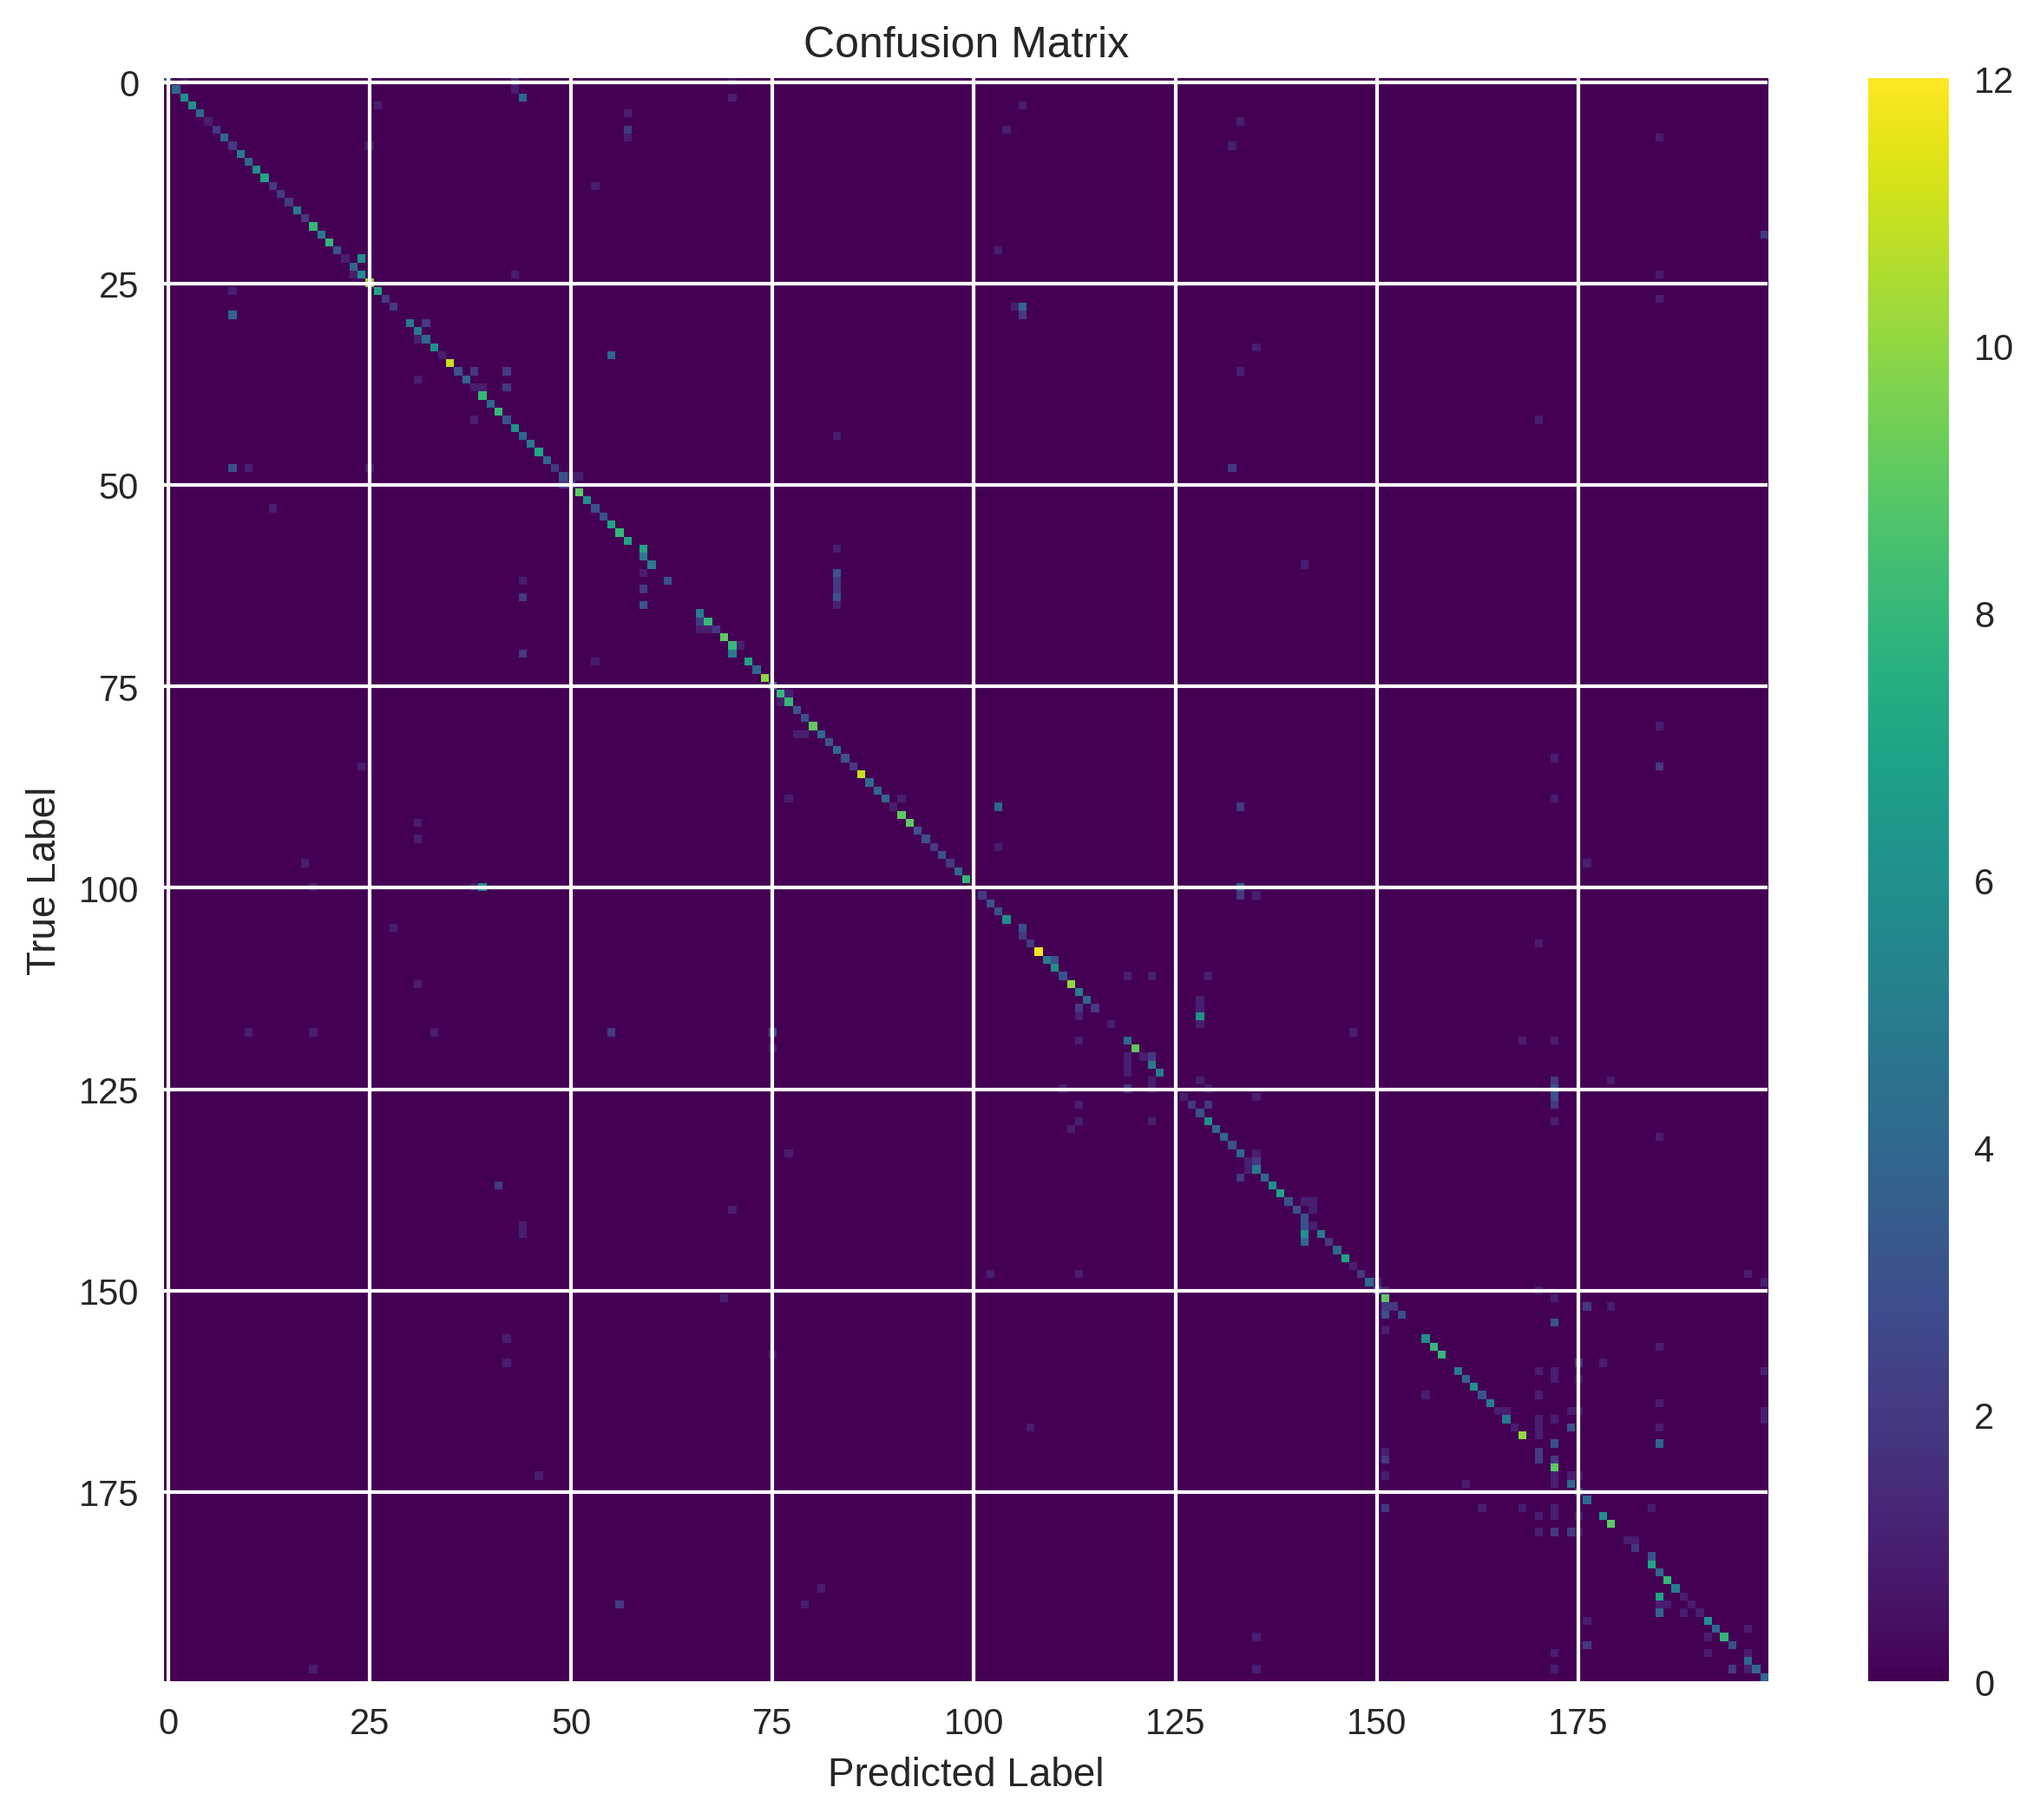

In [140]:
import sklearn
all_predictions = []
all_targets = []

with torch.no_grad():
    for step, batch in enumerate(test_loader_preprocessed, 0):
        warnings.filterwarnings('ignore')
        inputs, labels = batch
        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
        cbl_logits, logits = nets[0](**inputs)  
        all_predictions.extend(logits.argmax(dim=-1).cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

confusion_matrix = sklearn.metrics.confusion_matrix(y_true=all_targets, y_pred=all_predictions)

plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(confusion_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
#plt.savefig('cm_cub200_80.02_sparse.png')
plt.show()

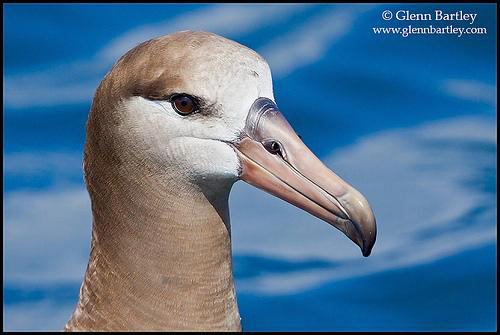

In [16]:
import PIL
image = PIL.Image.open('image.jpg')
image

In [17]:
processor = transformers.CLIPProcessor.from_pretrained(Constants.clip_large_link)
inputs = processor(text=concepts, images=image, return_tensors="pt", padding=True)

In [155]:
with torch.no_grad():
    for batch in test_loader_preprocessed:
        _, labels = batch
        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
        cbl_logits, logits = nets[0](**inputs)
        break

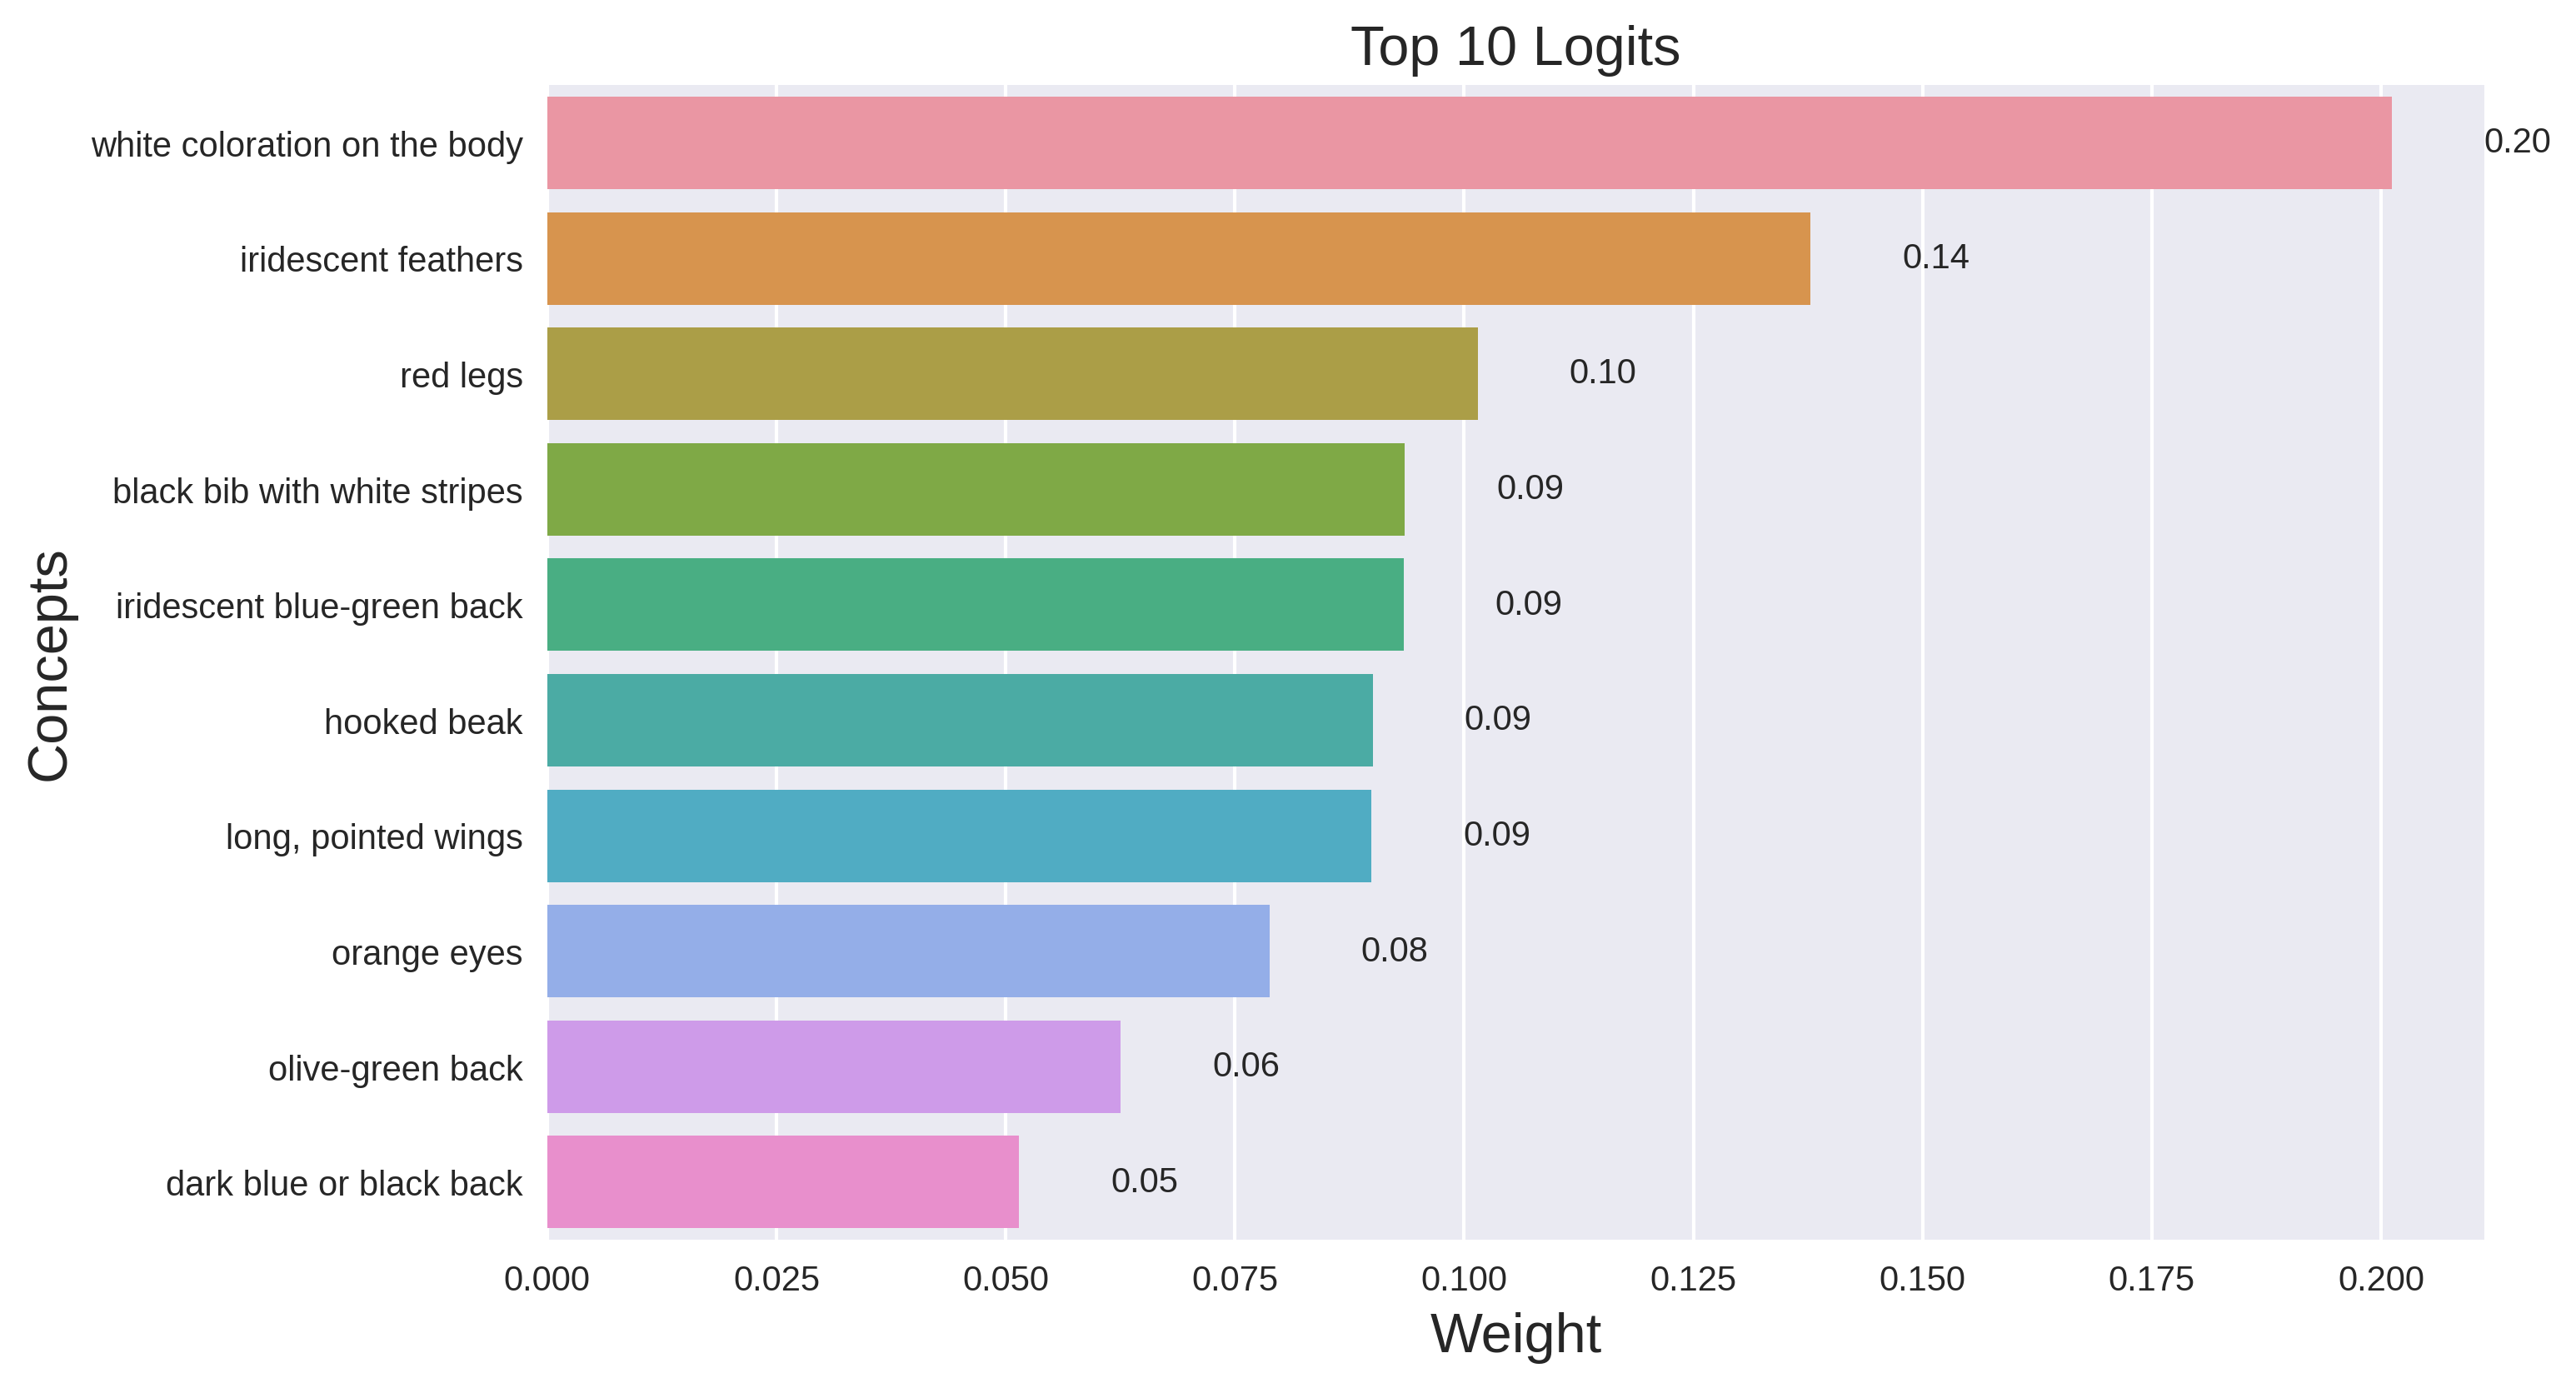

In [156]:
draw_bottleneck(image, cbl_logits, k=10, concepts=concepts, draw_probs=True)

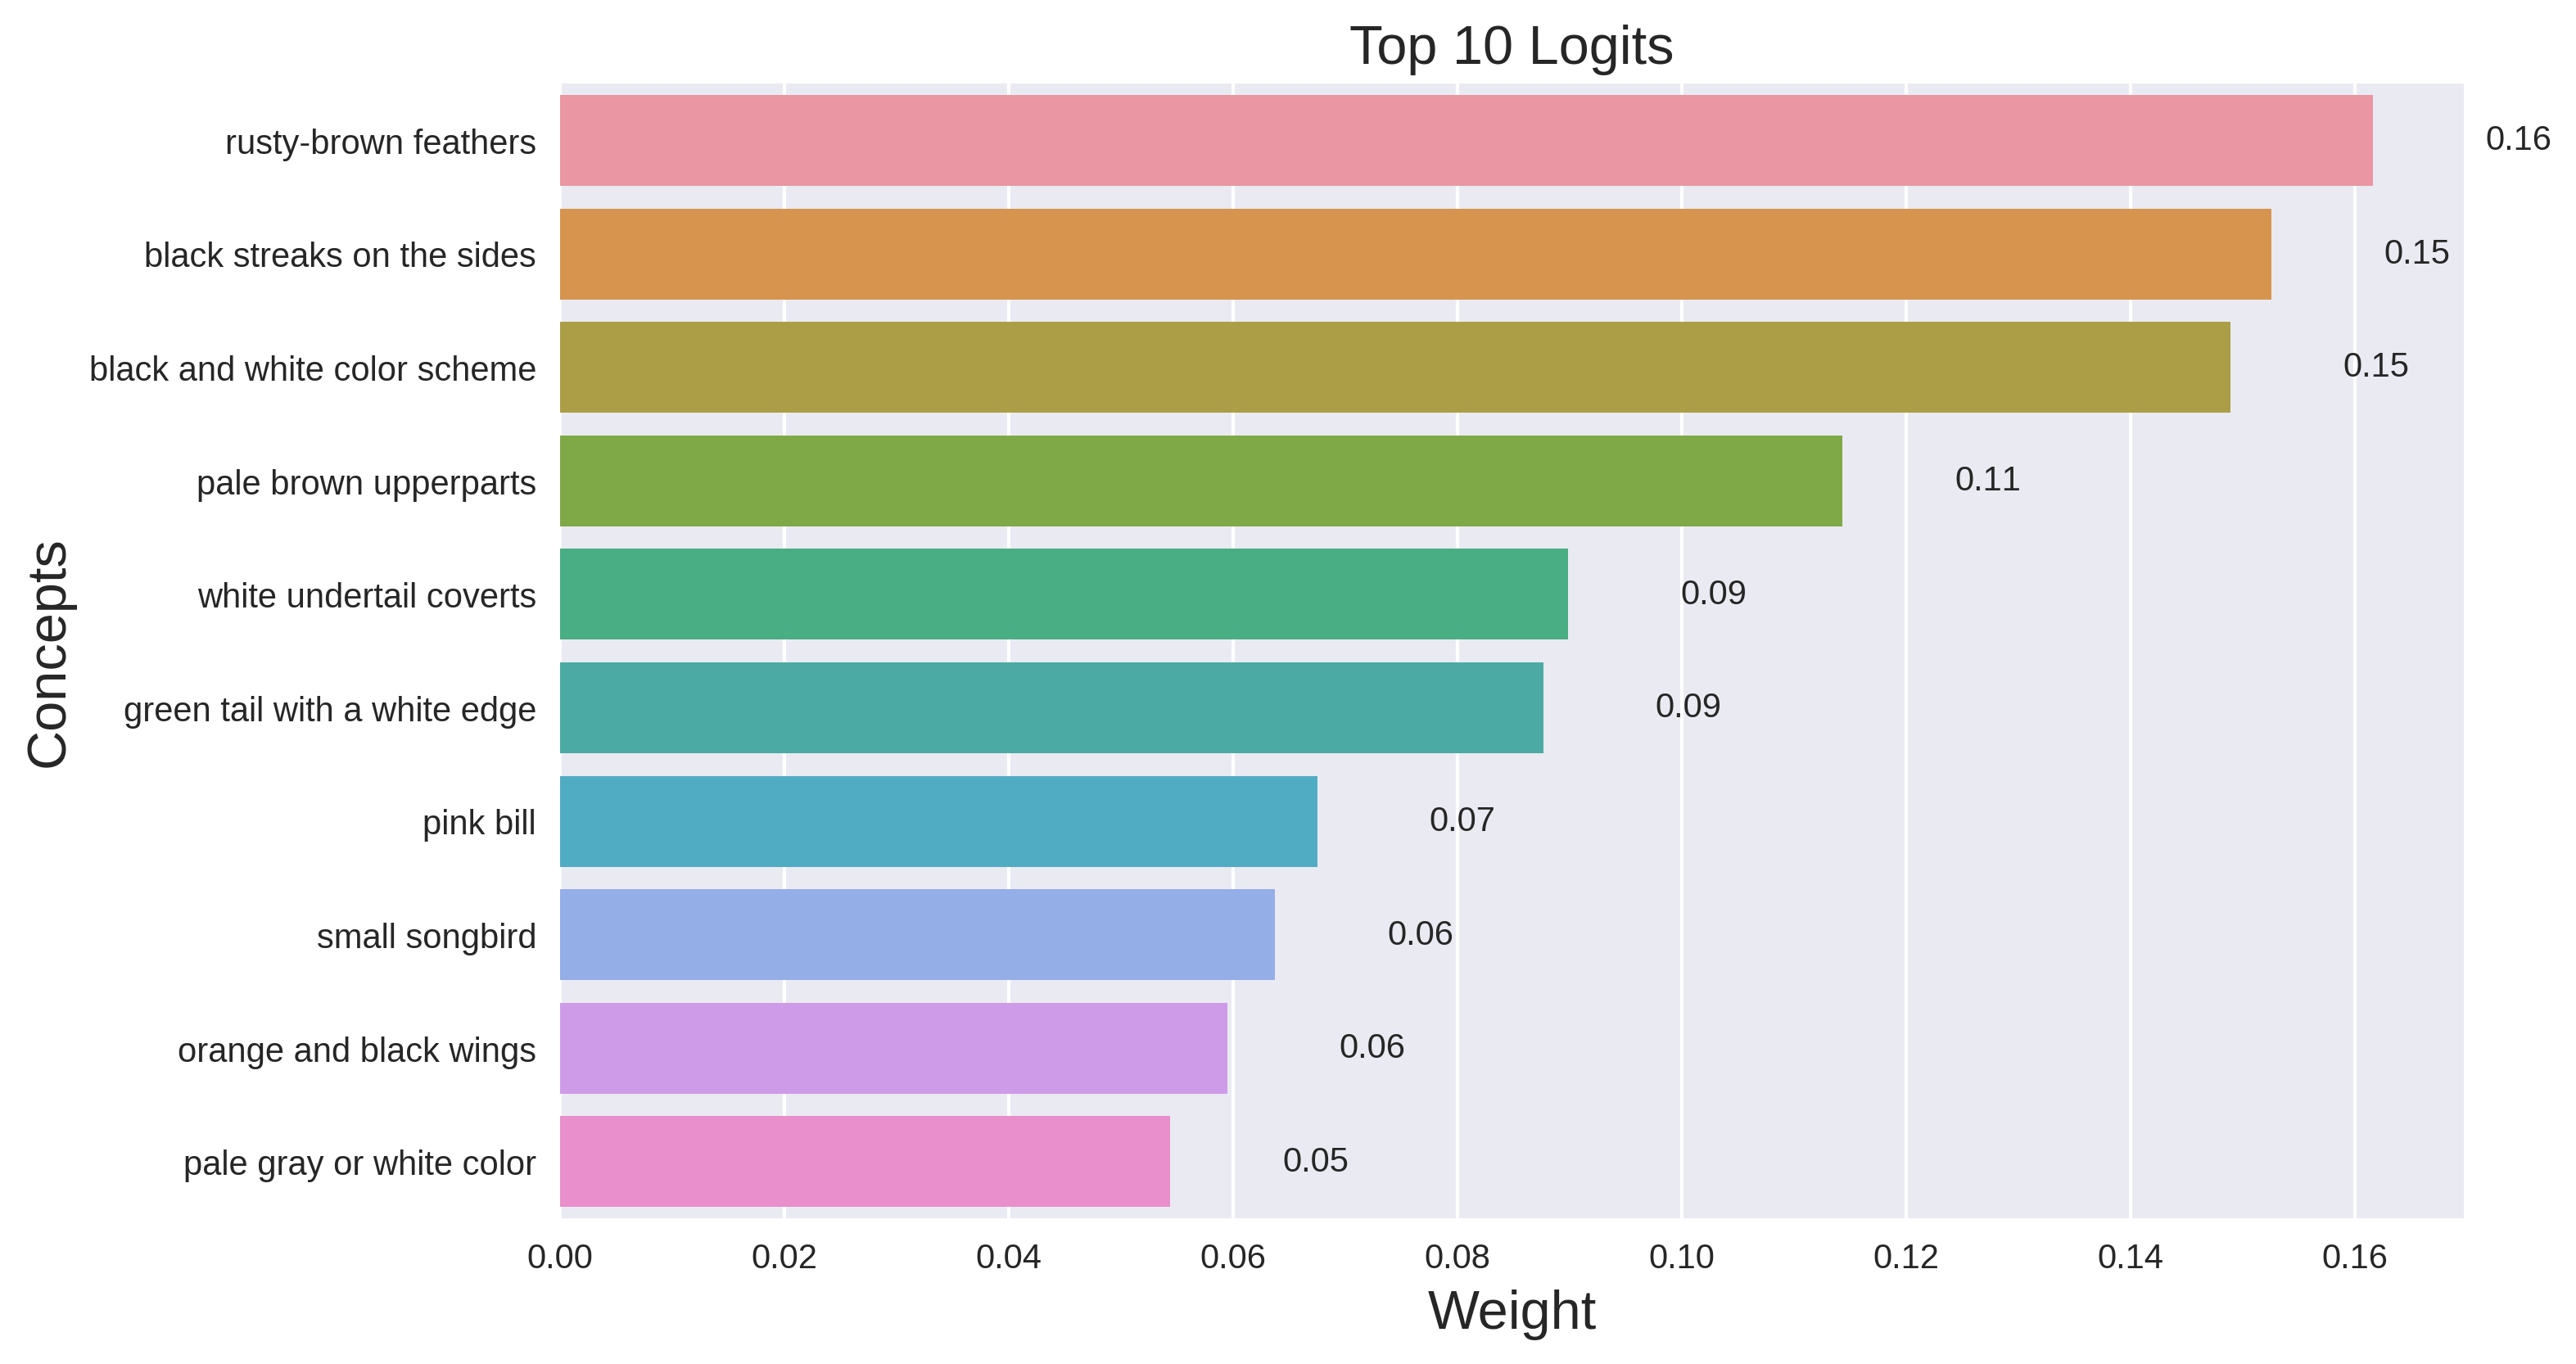

In [144]:
draw_bottleneck(image, cbl_logits, k=10, concepts=concepts, draw_probs=True)

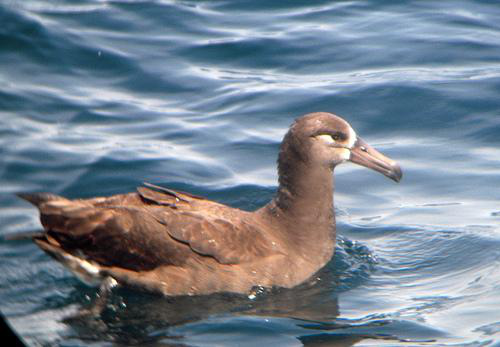

In [145]:
image_2 = PIL.Image.open('image-2.jpg')
image_2

In [146]:
inputs_2 = processor(text=concepts, images=image_2, return_tensors="pt", padding=True)

In [157]:
with torch.no_grad():
    for batch in test_loader_preprocessed:
        _, labels = batch
        inputs_2, targets = inputs_2.to(device), torch.LongTensor(labels).to(device)
        cbl_logits, logits = nets[0](**inputs_2)
        break

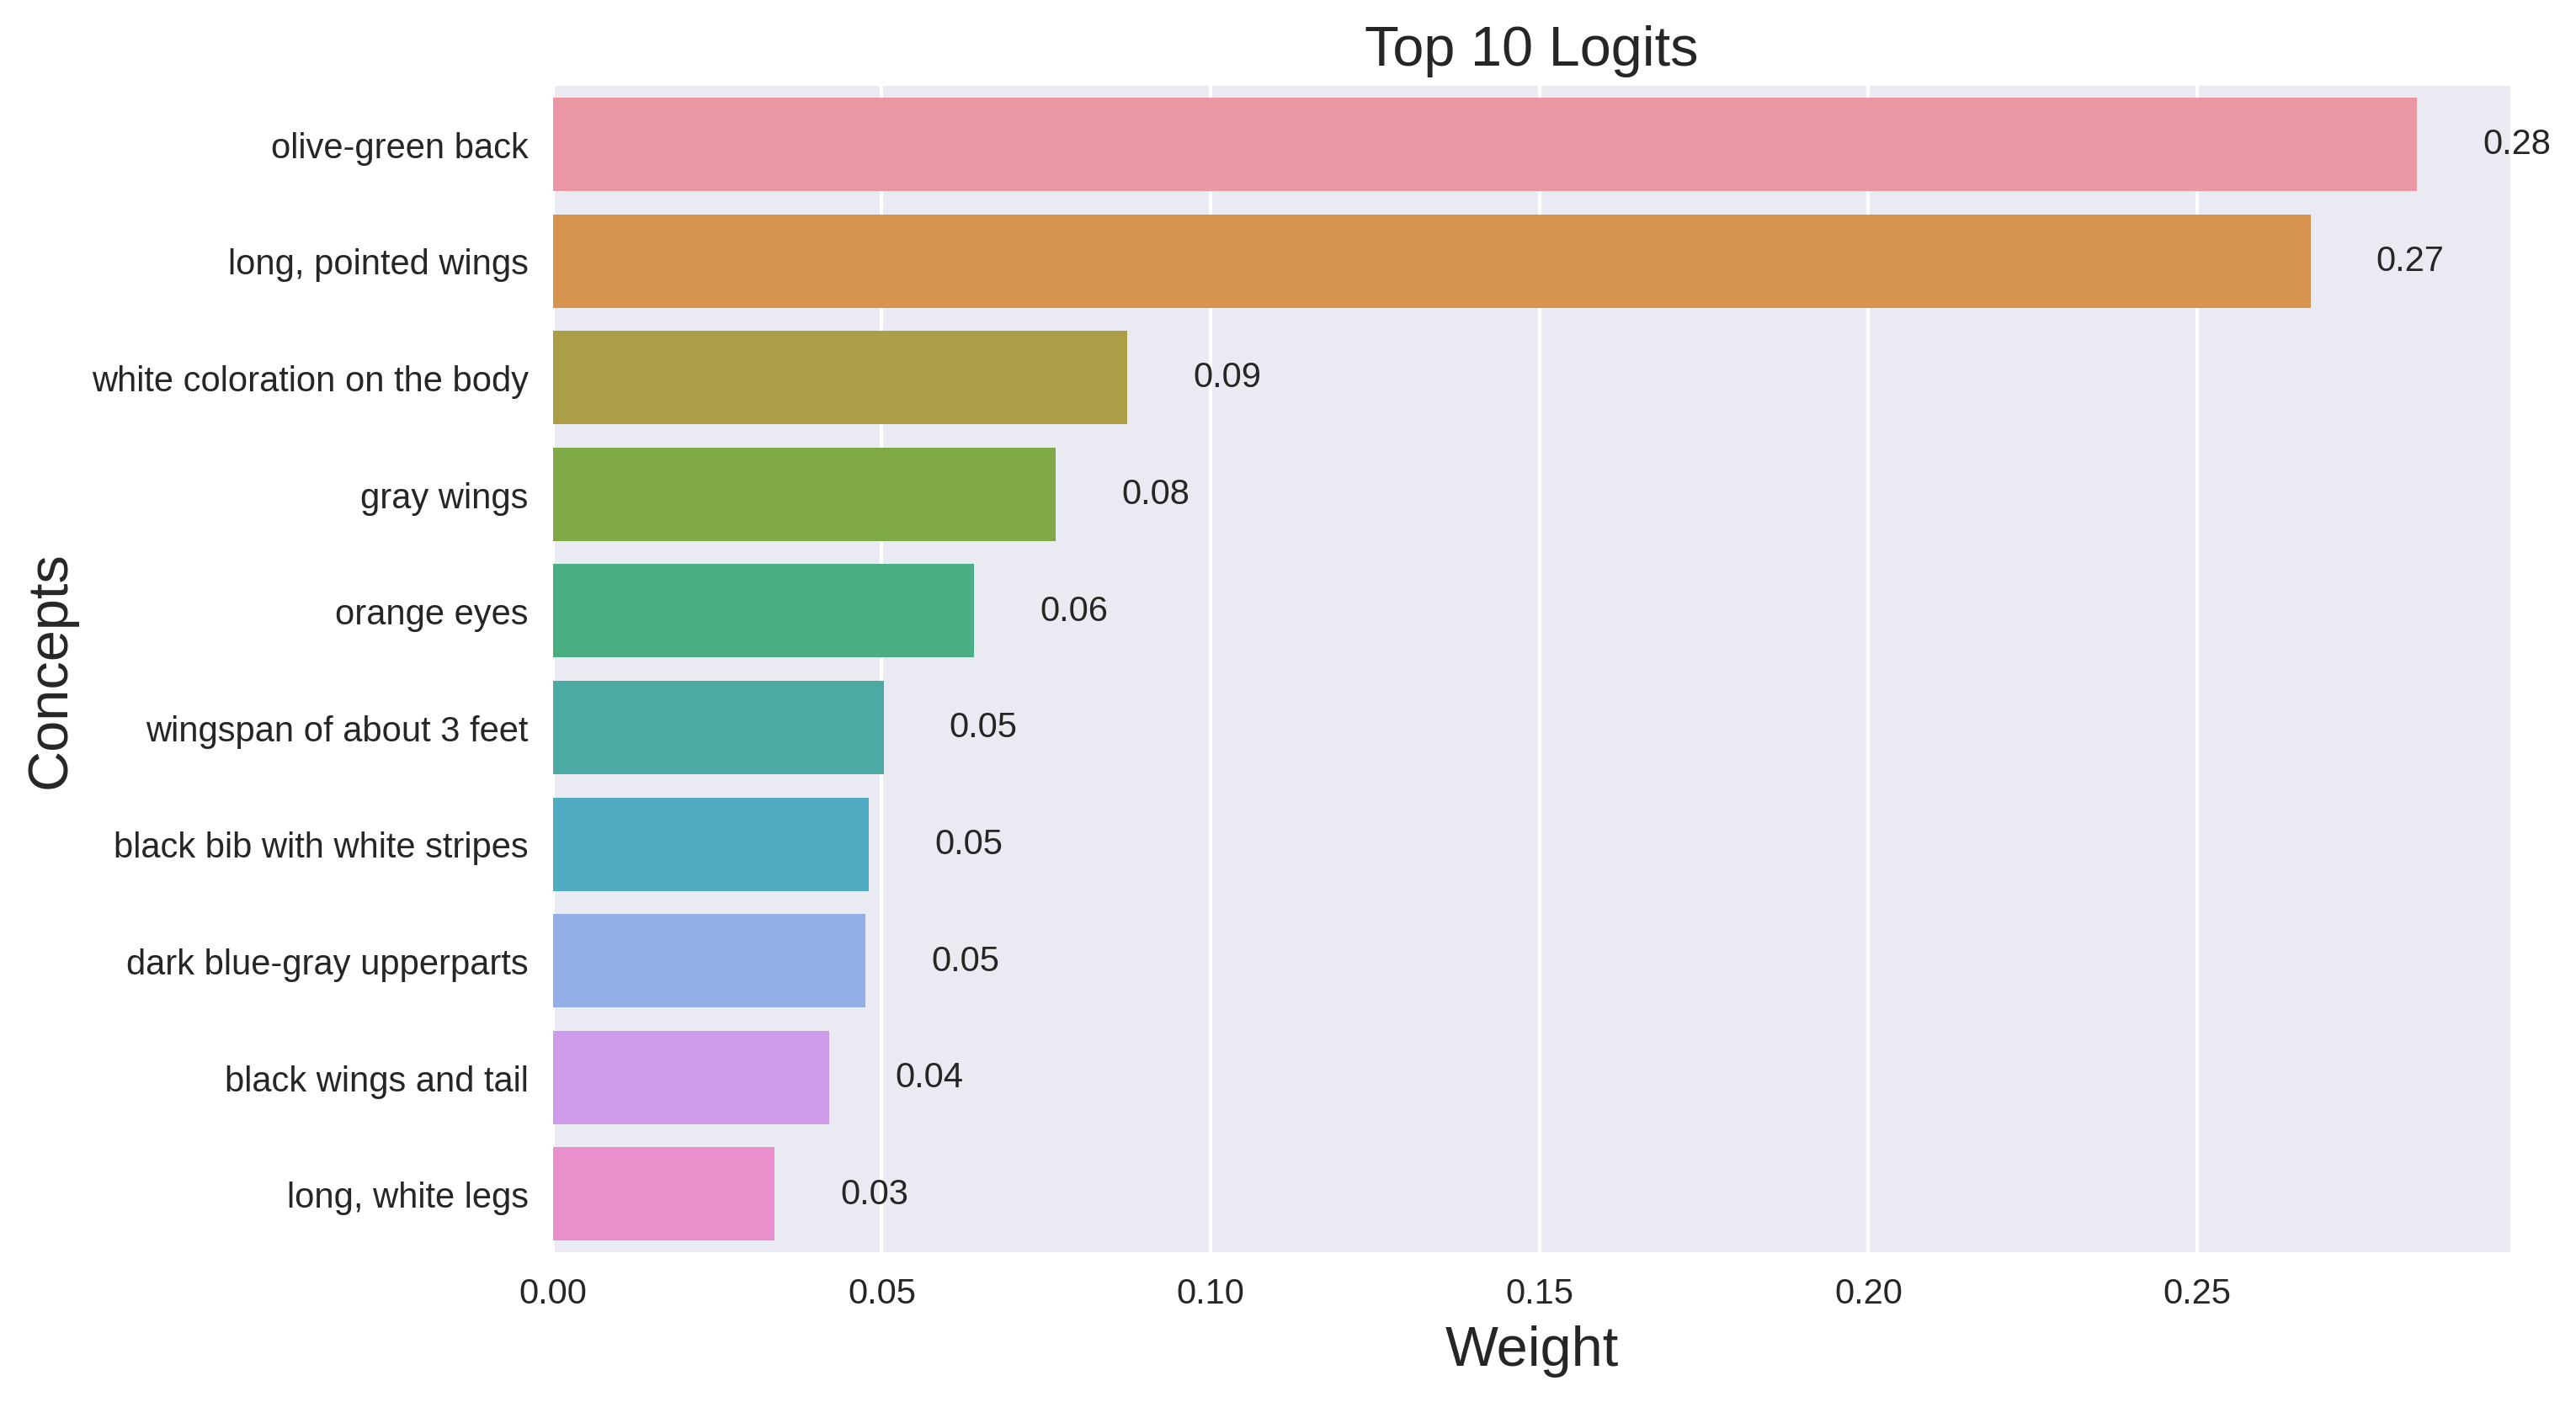

In [158]:
draw_bottleneck(image_2, cbl_logits, k=10, concepts=concepts, draw_probs=True)

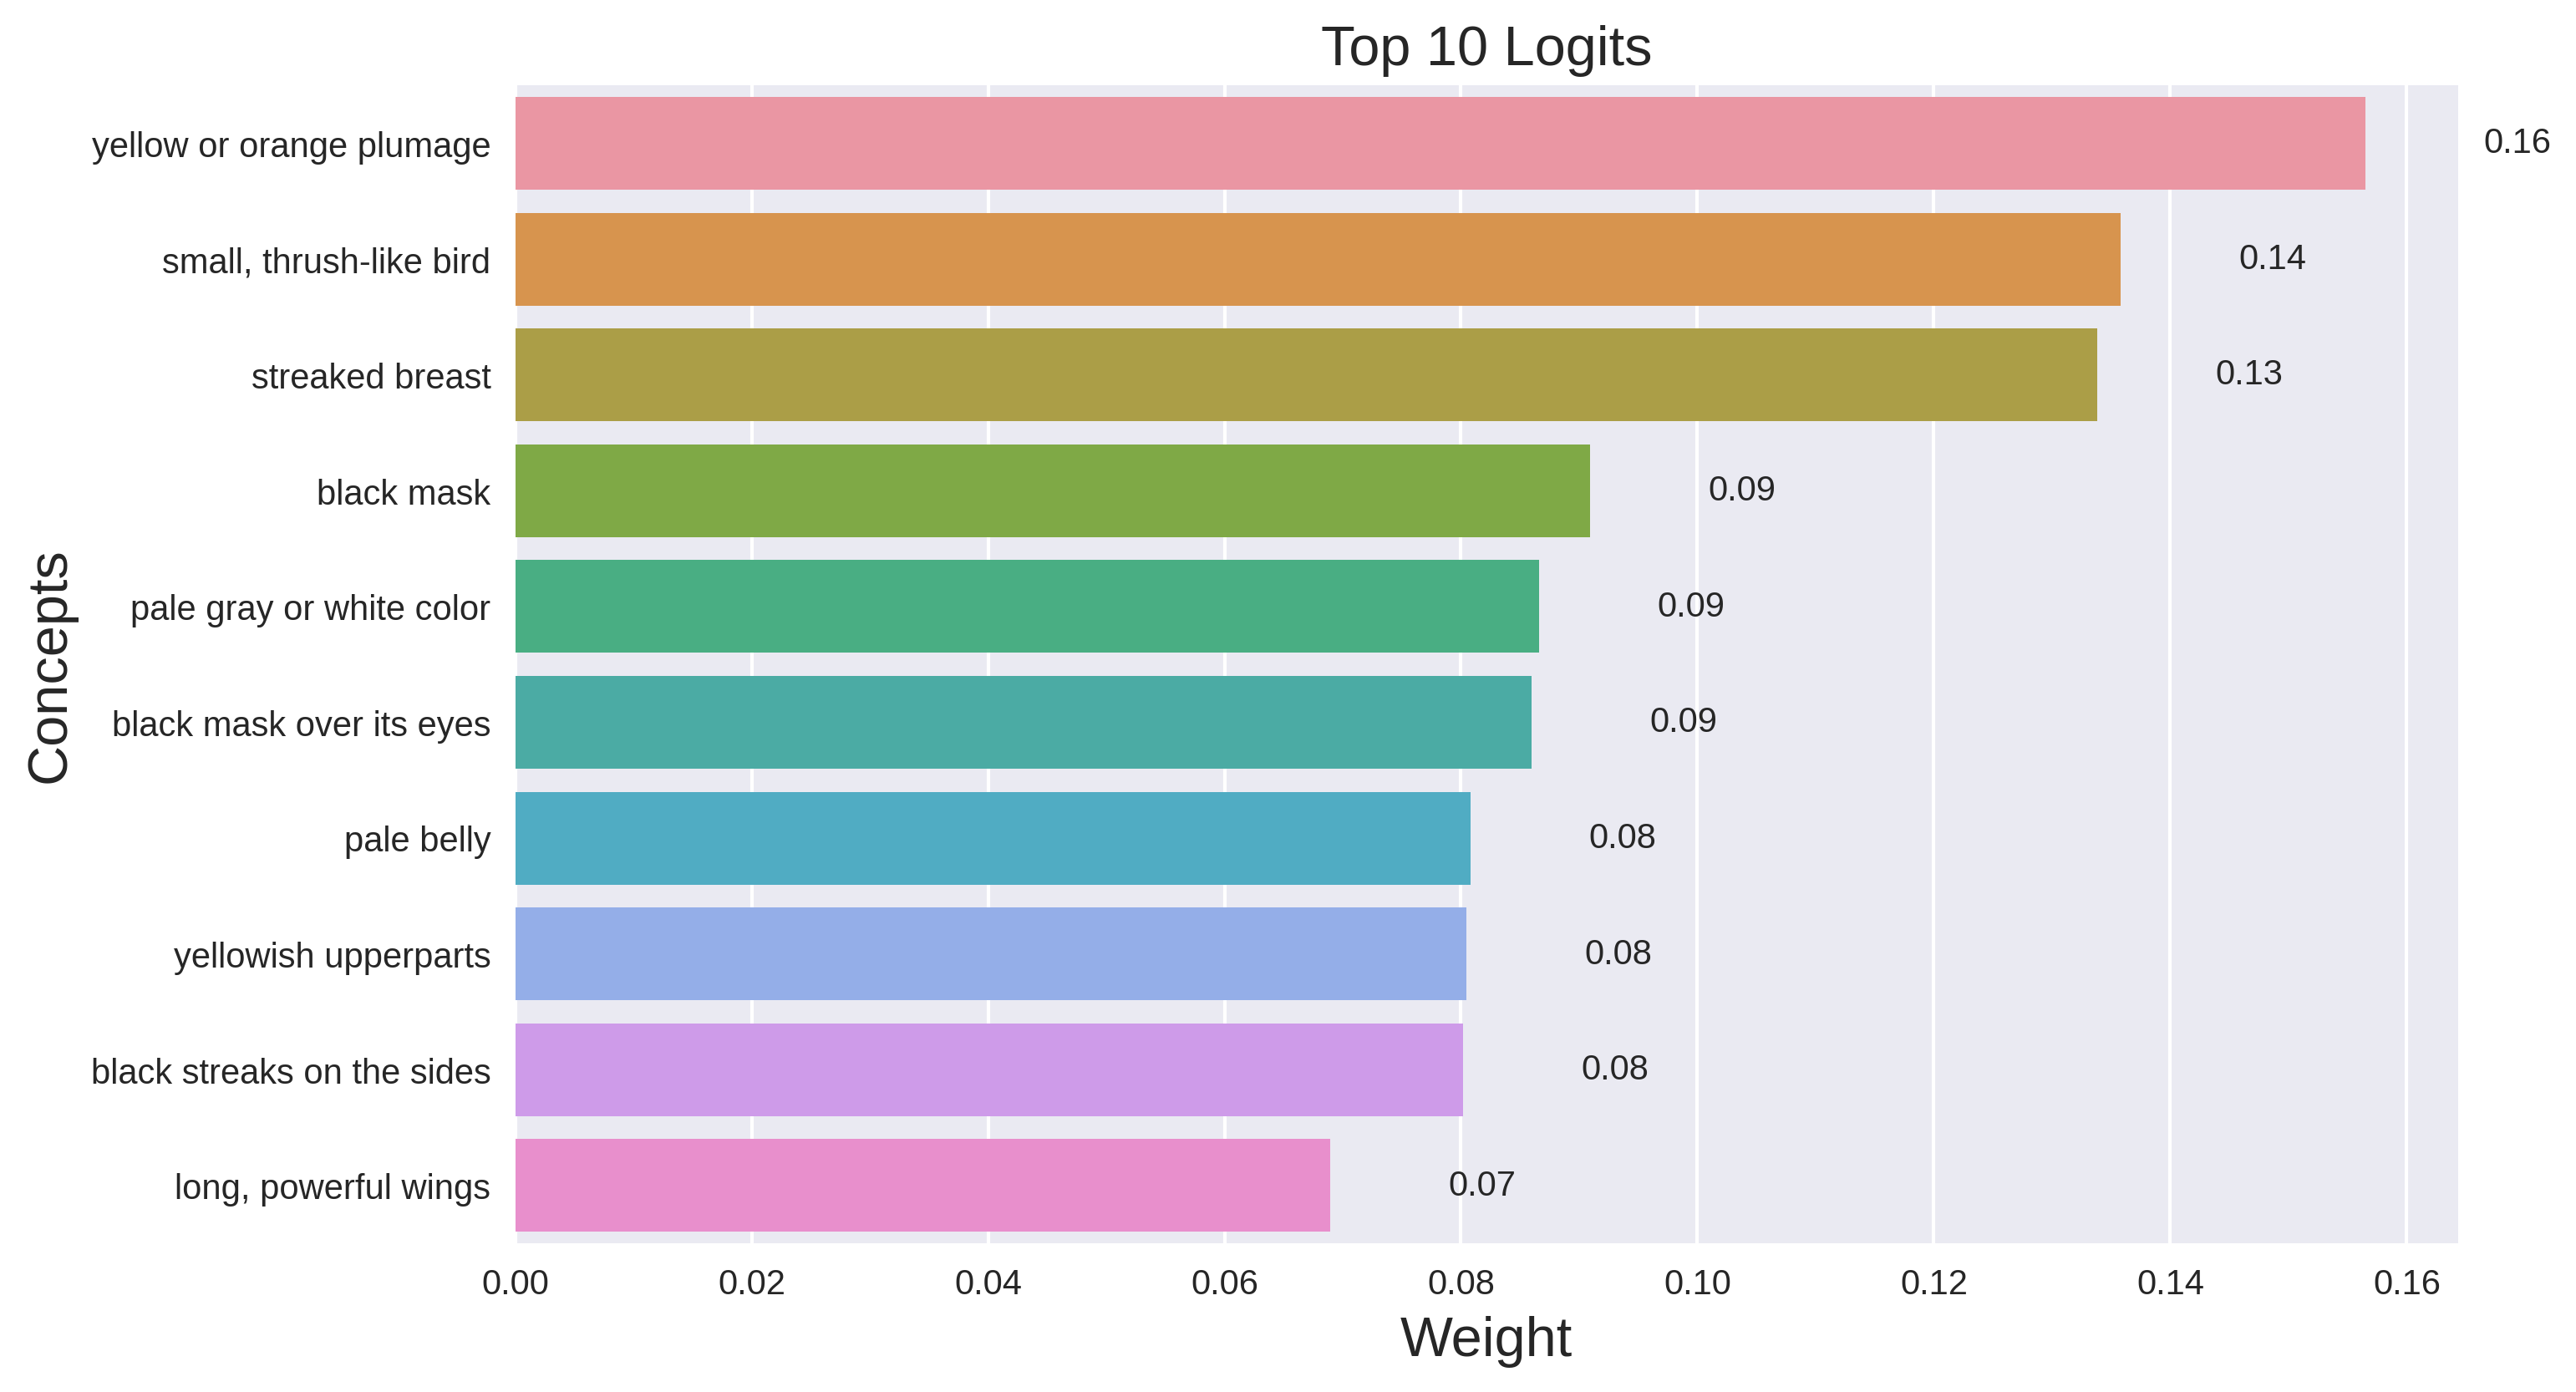

In [152]:
draw_bottleneck(image_2, cbl_logits, k=10, concepts=concepts, draw_probs=True)

## trainer

In [127]:
# ради теста
opts = []
for i in range(1):
    opts += [
        (torch.optim.Adam(nets[i * 2 + 0].cbl.parameters(), lr=1e-3),
         torch.optim.Adam(nets[i * 2 + 0].head.parameters(), lr=0.0001)),
        
        (torch.optim.Adam(nets[i * 2 + 1].cbl.parameters(), lr=1e-5), 
         torch.optim.Adam(nets[i * 2 + 1].head.parameters(), lr=0.0001)),
         ]

opt_names = [
    "CLIP-L, 1e-3, 1e-4",
    #"AdamW, 0.001, bs_mul = 1",
    "CLIP-L, 1e-5, 1e-4",
] * 1

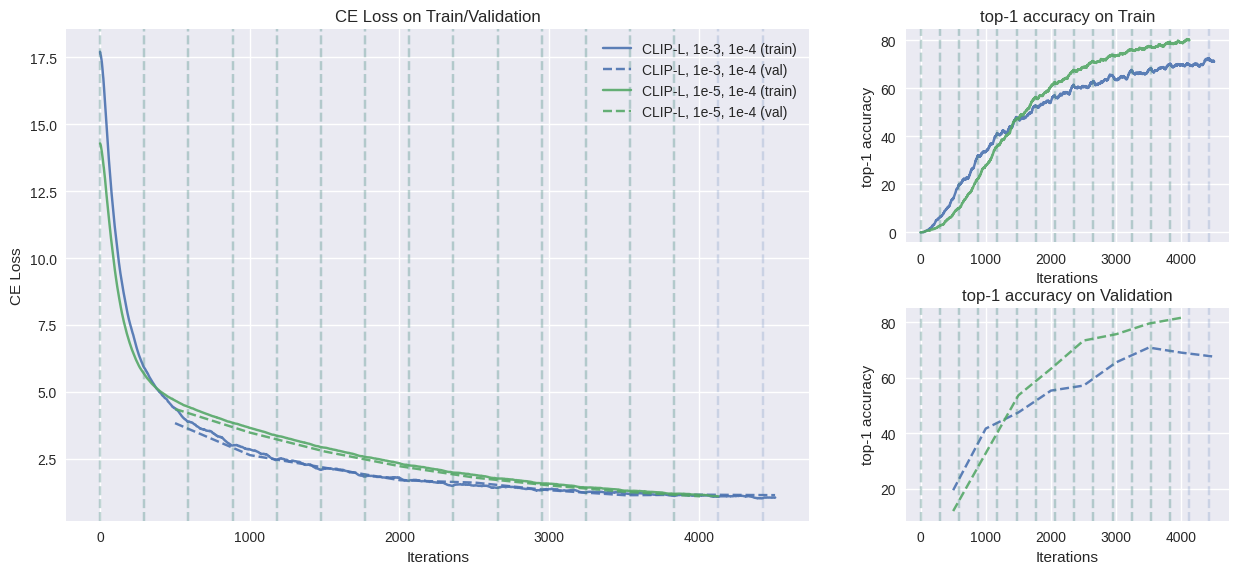

KeyboardInterrupt: 

In [136]:
trainer.train()

In [137]:
trainer.test()

Begin Testing


0it [00:00, ?it/s]

67.91166171512089 

79.98936441782358 

Finished Testing


In [196]:
config = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=200,
    run_name="trainer_with_config2",
    backbones=[Constants.clip_base_link, Constants.clip_large_link],
    displayed_names=["CLIP-ViT-B/32, gumbel, 3e-4", "CLIP-ViT-L/14, contrastive, 3e-4"],
    training_methods=["gumbel", "contrastive"],
    optimizers=["Adam", "AdamW"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
)

trainer = BottleneckTrainer(
    config,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=10,
)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


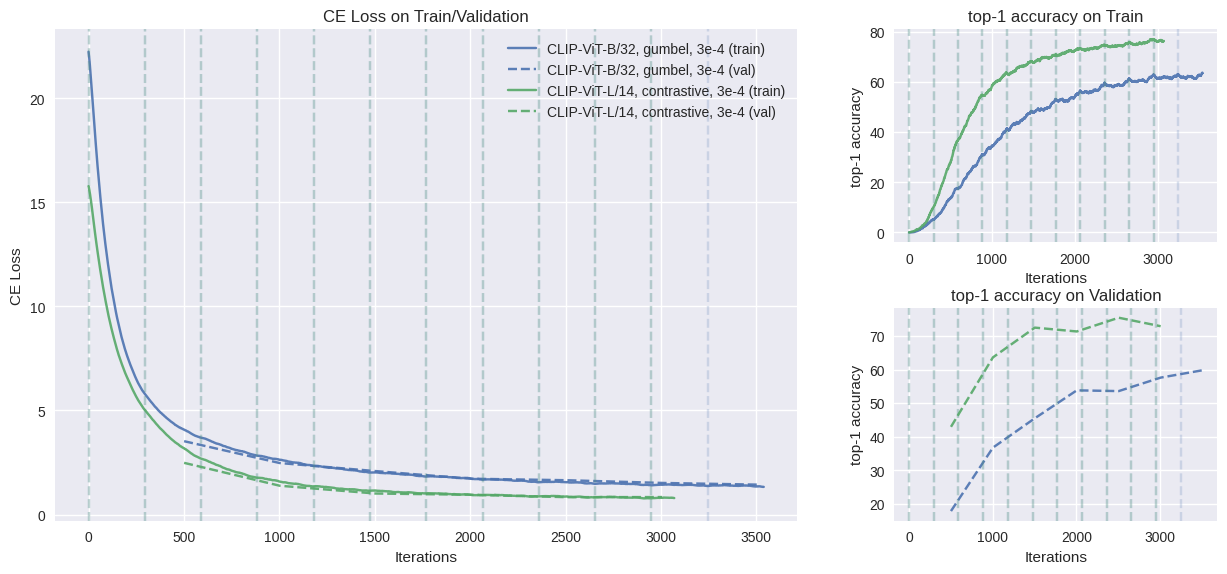

KeyboardInterrupt: 

In [199]:
trainer.train()

In [200]:
trainer.test()

Begin Testing


0it [00:00, ?it/s]

54.01338835020323 

74.2836586204735 

Finished Testing


In [217]:
config = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=200,
    run_name="trainer_with_config2",
    backbones=[Constants.clip_base_link, Constants.clip_large_link],
    displayed_names=["CLIP-ViT-B/32, gumbel, 3e-4", "CLIP-ViT-L/14, contrastive, 3e-4"],
    training_methods=["gumbel", "contrastive"],
    optimizers=["Adam", "AdamW"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
)

trainer = BottleneckTrainer(
    config,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=10,
)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


In [253]:
trainer = BottleneckTrainer(
    config,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=10,
)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.


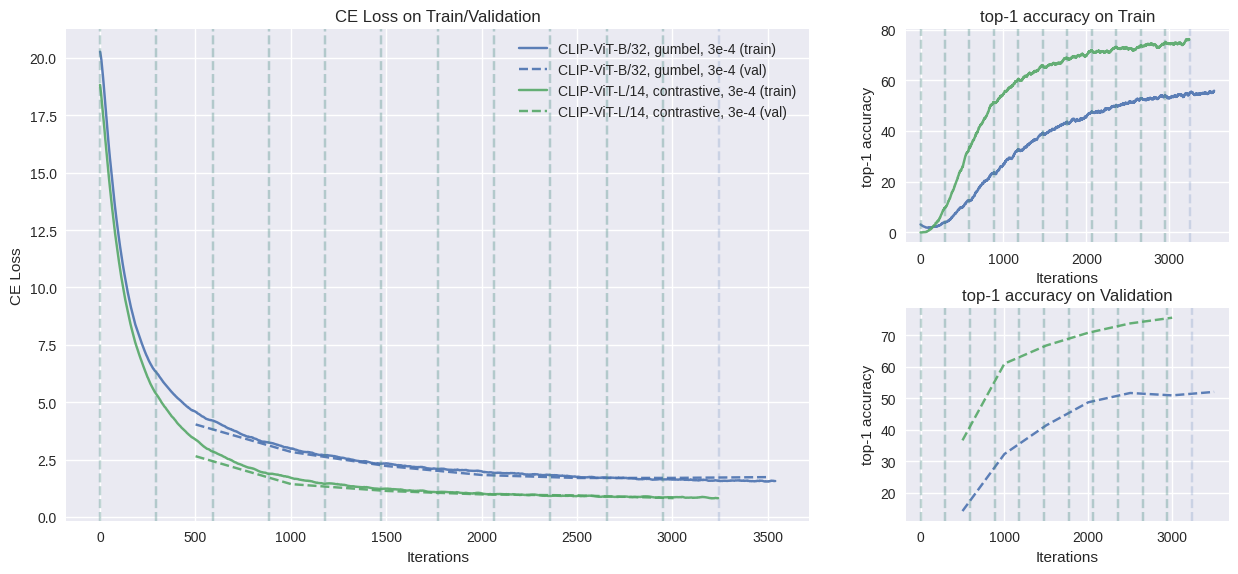

Finished Training


In [256]:
trainer.train()

In [257]:
trainer.test()

Begin Testing


0it [00:00, ?it/s]

51.701701705520215 

68.94707200333879 

Finished Testing


In [57]:
config = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=200,
    run_name="similarity_test",
    backbones=[Constants.clip_large_link, Constants.clip_large_link],
    displayed_names=["CLIP-ViT-L/14, gumbel, 3e-4", "CLIP-ViT-L/14, similarity, 3e-4"],
    training_methods=["gumbel", "similarity"],
    optimizers=["Adam", "Adam"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
)

In [ ]:
trainer = BottleneckTrainer(
    config,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=1,
)

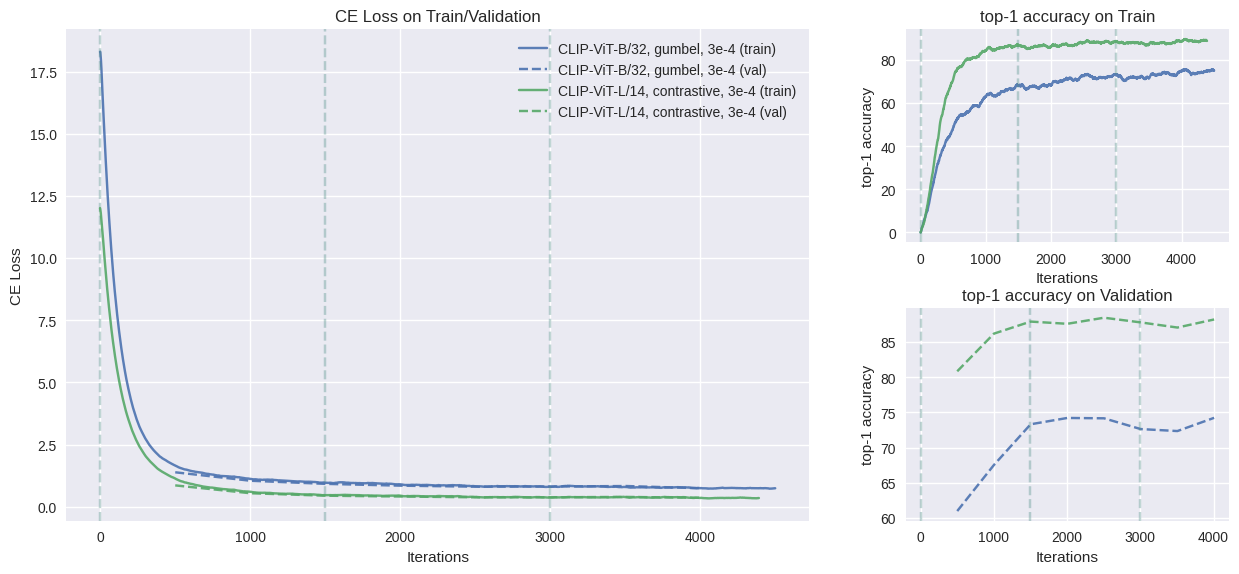

KeyboardInterrupt: 

In [28]:
trainer.train()

In [29]:
trainer.test()

Begin Testing


0it [00:00, ?it/s]

72.39029255319149 

88.53058510638297 

Finished Testing


In [45]:
trainer.hist[1].keys()

dict_keys(['run_name', 'name', 'bs_mul', 'train_loss', 'train_x', 'val_loss', 'val_x', 'train_cbl_loss', 'val_cbl_loss', 'train_acc_top_1', 'train_acc_top_5', 'test_acc_top_1', 'test_acc_top_5', 'val_acc_top_1', 'val_acc_top_5', 'val_precision', 'val_recall', 'val_f1', 'test_precision', 'test_recall', 'test_f1', 'norm_diffs', 'epochs_x', 'norm_diffs_x', 'total_steps', 'prev_val_eval_step', 'prev_grad_norms_eval_step', 'batch_end'])

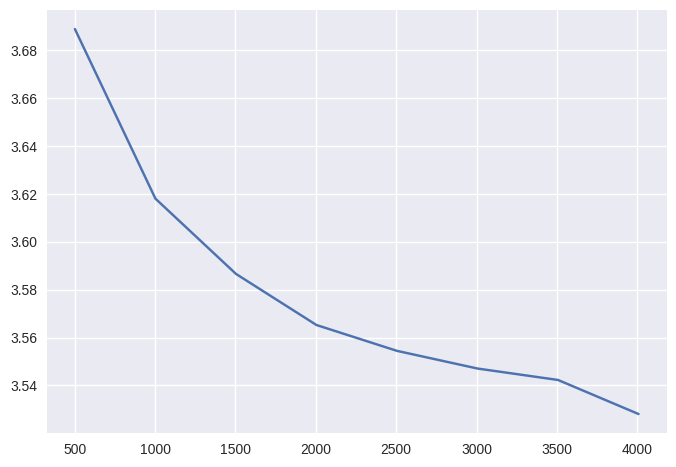

In [49]:
plt.plot(trainer.hist[1]['val_x'], trainer.hist[1]['val_cbl_loss'])

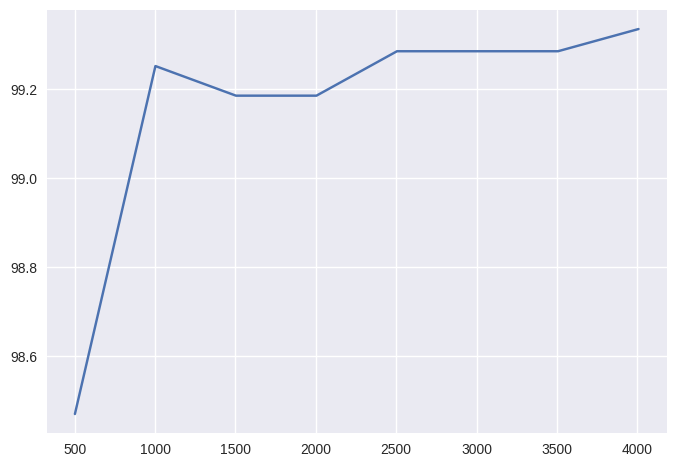

In [51]:
plt.plot(trainer.hist[1]['val_x'], trainer.hist[1]['val_acc_top_5'])

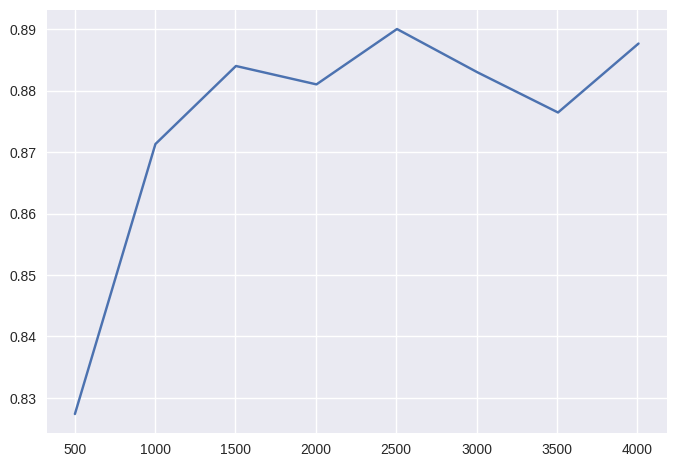

In [46]:
plt.plot(trainer.hist[1]['val_x'], trainer.hist[1]['val_f1'])

In [10]:
config = CBMConfig(
    num_nets=2,
    num_concepts=len(concepts),
    num_classes=200,
    run_name="similarity_test",
    backbones=[Constants.clip_base_link, Constants.clip_base_link],
    displayed_names=["CLIP-ViT-L/14, similarity, 3e-4", "CLIP-ViT-L/14, gumbel, 3e-4"],
    training_methods=["similarity", "gumbel"],
    optimizers=["Adam", "Adam"],
    lrs=[3e-4, 3e-4],
    cbl_lrs=[3e-4, 3e-4],
    train_backbones=[False, False],
)

In [11]:
trainer = BottleneckTrainer(
    config,
    train_loader_preprocessed,
    val_loader_preprocessed,
    test_loader_preprocessed,
    num_epochs=2,
    device=device,
)

In [51]:
from cbm import *
from trainer_utils import *

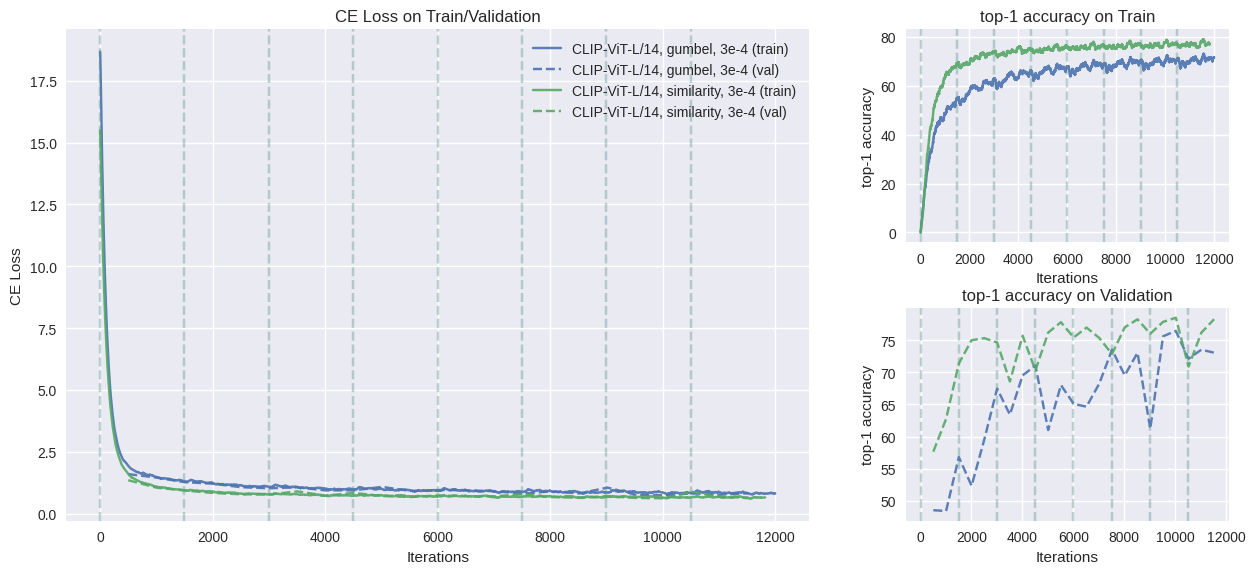

In [ ]:
# Trainer with similarity loss
# The blue one is SIMILARITY, the second one (green) is GUMBEL
trainer.train()

In [ ]:
# Trainer with similarity loss
# The blue one is SIMILARITY, the second one (green) is GUMBEL
trainer.train()

In [6]:
def criterion_similarity(logits_per_image: torch.Tensor, cbl_logits: torch.Tensor, is_cubed: bool=False) -> torch.Tensor:
    """
    Implementation of cosine similarity loss between .logits_per_image and outputs of CBL layer
    CLIP-like models normalize its logits_per_image outputs, in this case, only the normalization of
    CBL layer outputs is necessary. But we are trying to normalize both inputs.
    """
    logits_per_image = logits_per_image - torch.mean(logits_per_image, dim=0, keepdim=True)
    cbl_logits = cbl_logits - torch.mean(cbl_logits, dim=0, keepdim=True)
    if is_cubed == True:
        logits_per_image = logits_per_image ** 3
        cbl_logits = cbl_logits ** 3
    logits_per_image = logits_per_image / torch.norm(logits_per_image, p=2, dim=0, keepdim=True)
    cbl_logits = cbl_logits / torch.norm(cbl_logits, p=2, dim=0, keepdim=True)
    similarities = torch.sum(cbl_logits * logits_per_image, dim=0)
    return torch.mean(similarities)

criterion_similarity(torch.randn(2,3), torch.randn(2,3))

tensor(-0.3333)

In [13]:
trainer.test()

Begin Testing


0it [00:00, ?it/s]

71.72539893617021 

73.10505319148936 

Finished Testing


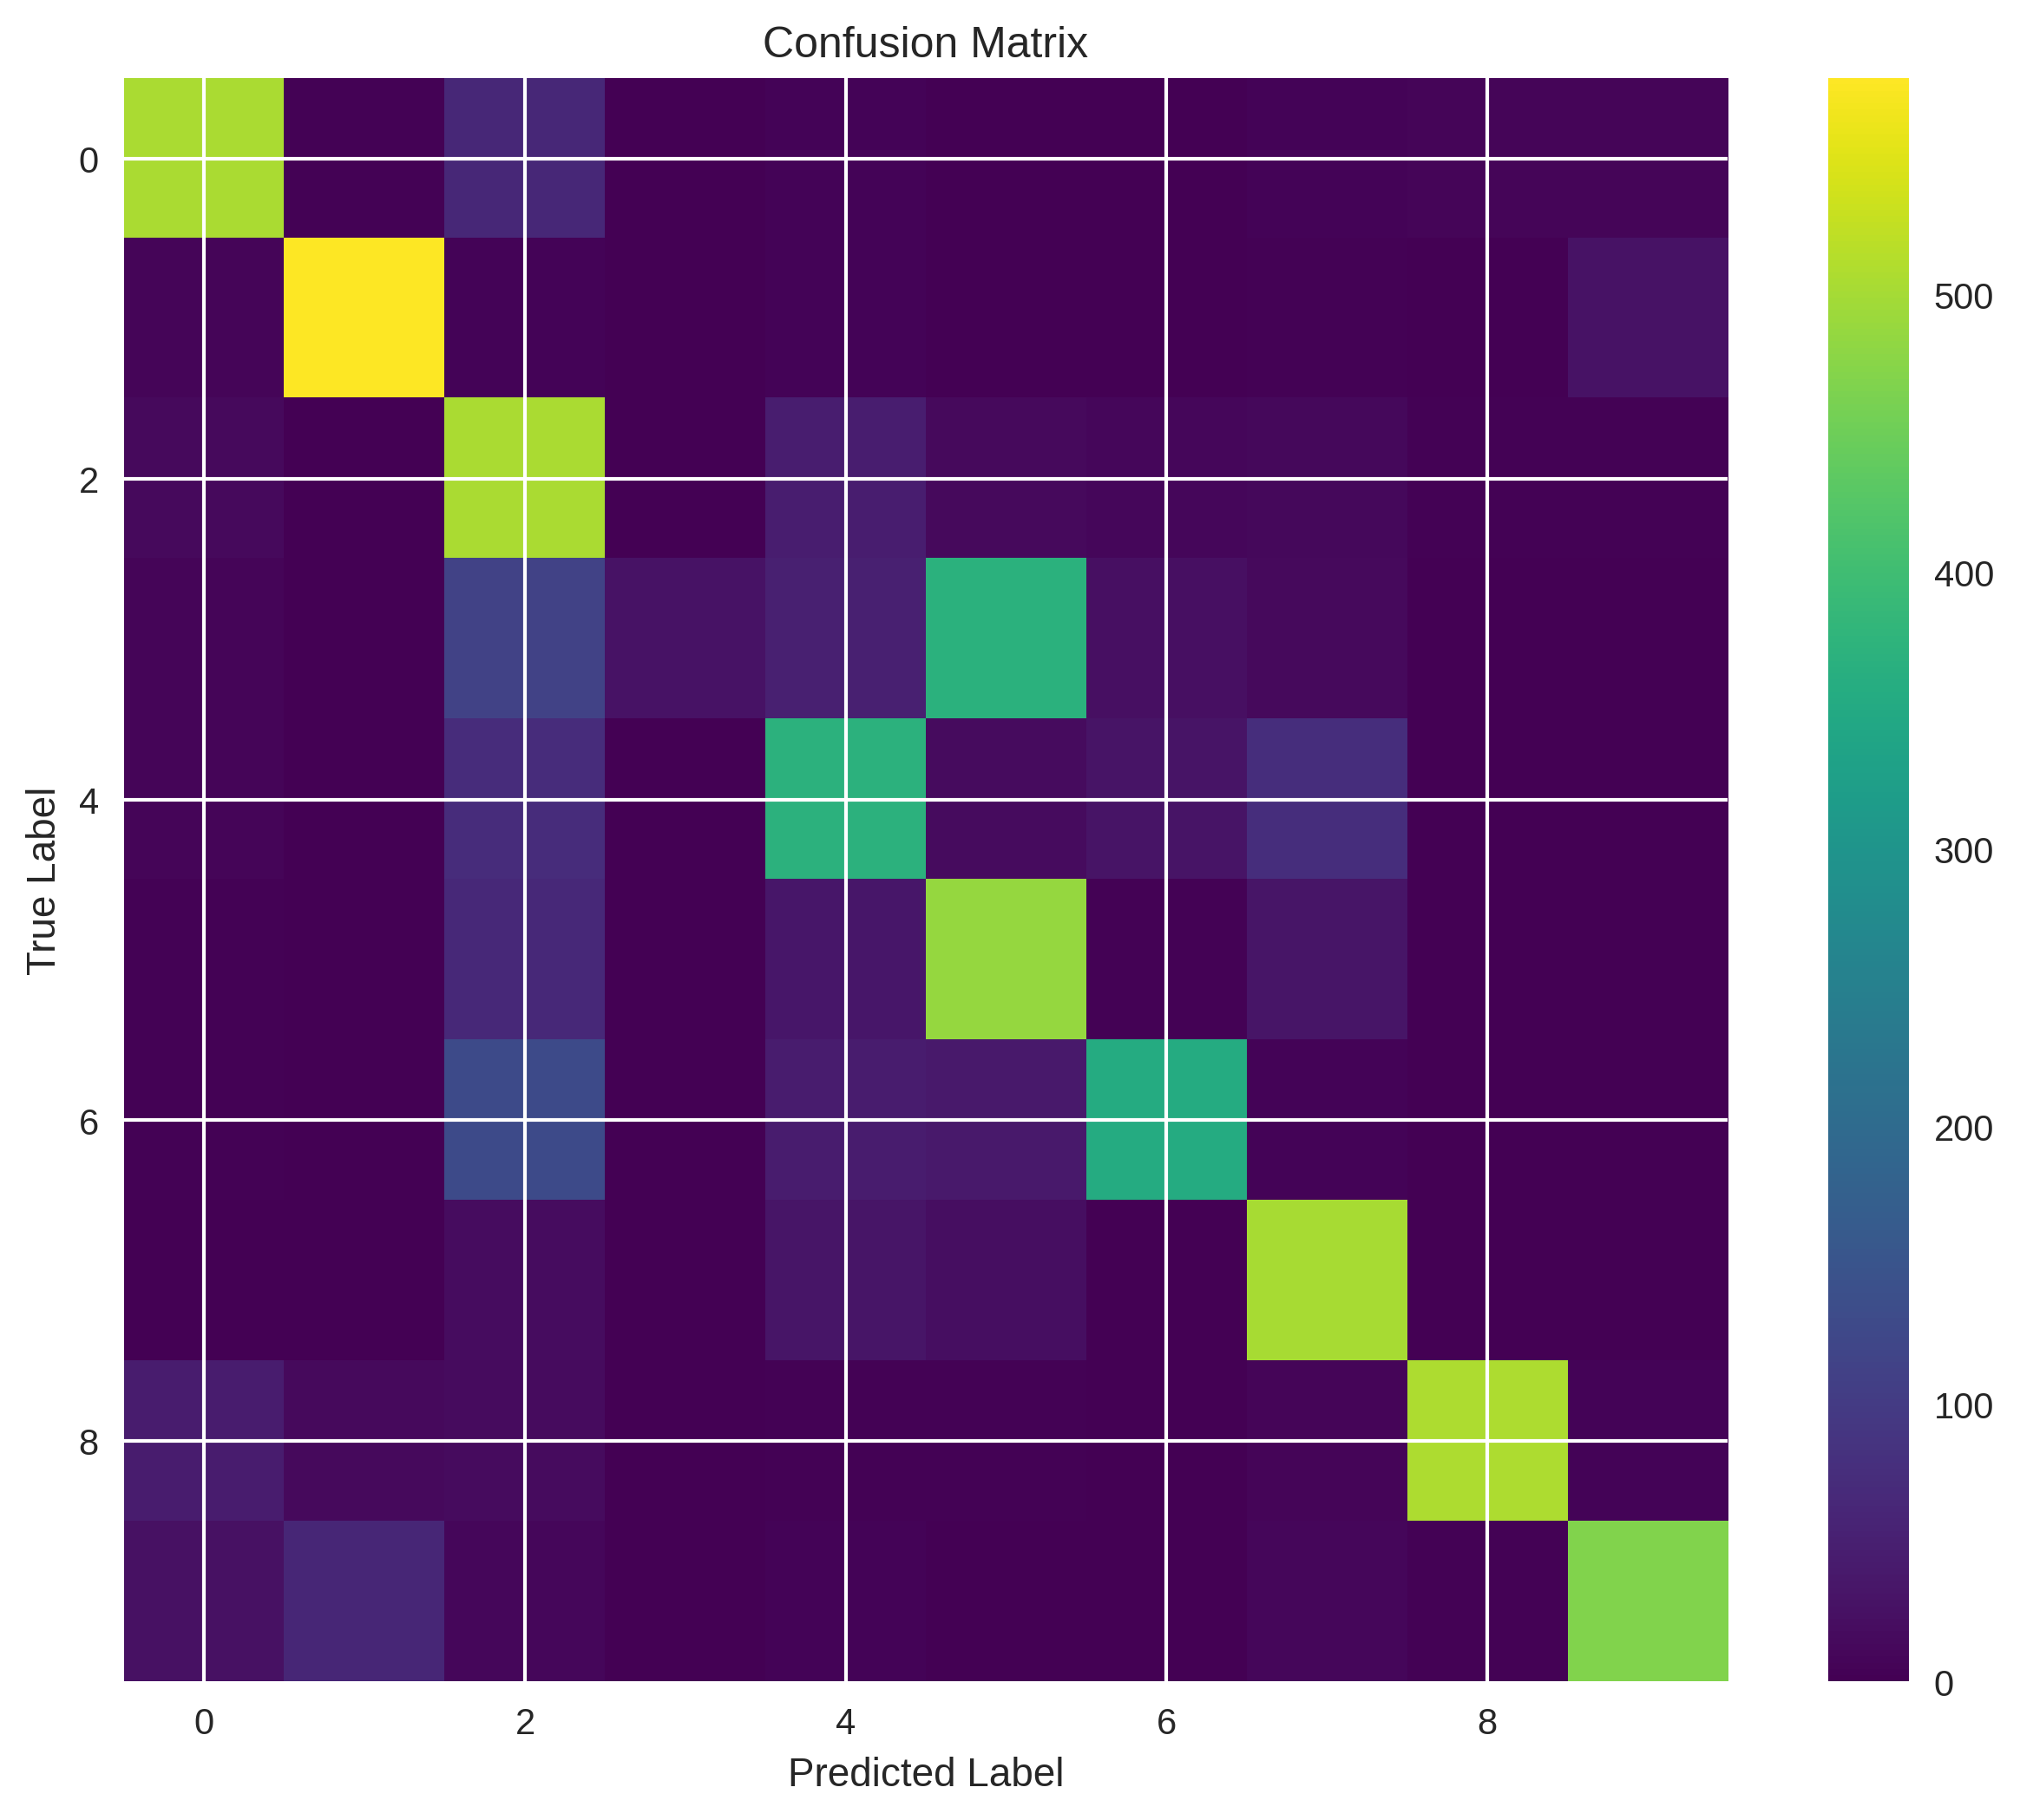

In [14]:
import sklearn
all_predictions = []
all_targets = []

with torch.no_grad():
    for step, batch in enumerate(test_loader_preprocessed, 0):
        warnings.filterwarnings('ignore')
        inputs, labels = batch
        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
        cbl_logits, logits = trainer.nets[0](**inputs)  
        all_predictions.extend(logits.argmax(dim=-1).cpu().tolist())
        all_targets.extend(targets.cpu().tolist())

confusion_matrix = sklearn.metrics.confusion_matrix(y_true=all_targets, y_pred=all_predictions)

plt.figure(figsize=(10, 8), dpi=300)
plt.imshow(confusion_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
#plt.savefig('cm_cub200_80.02_sparse.png')
plt.show()

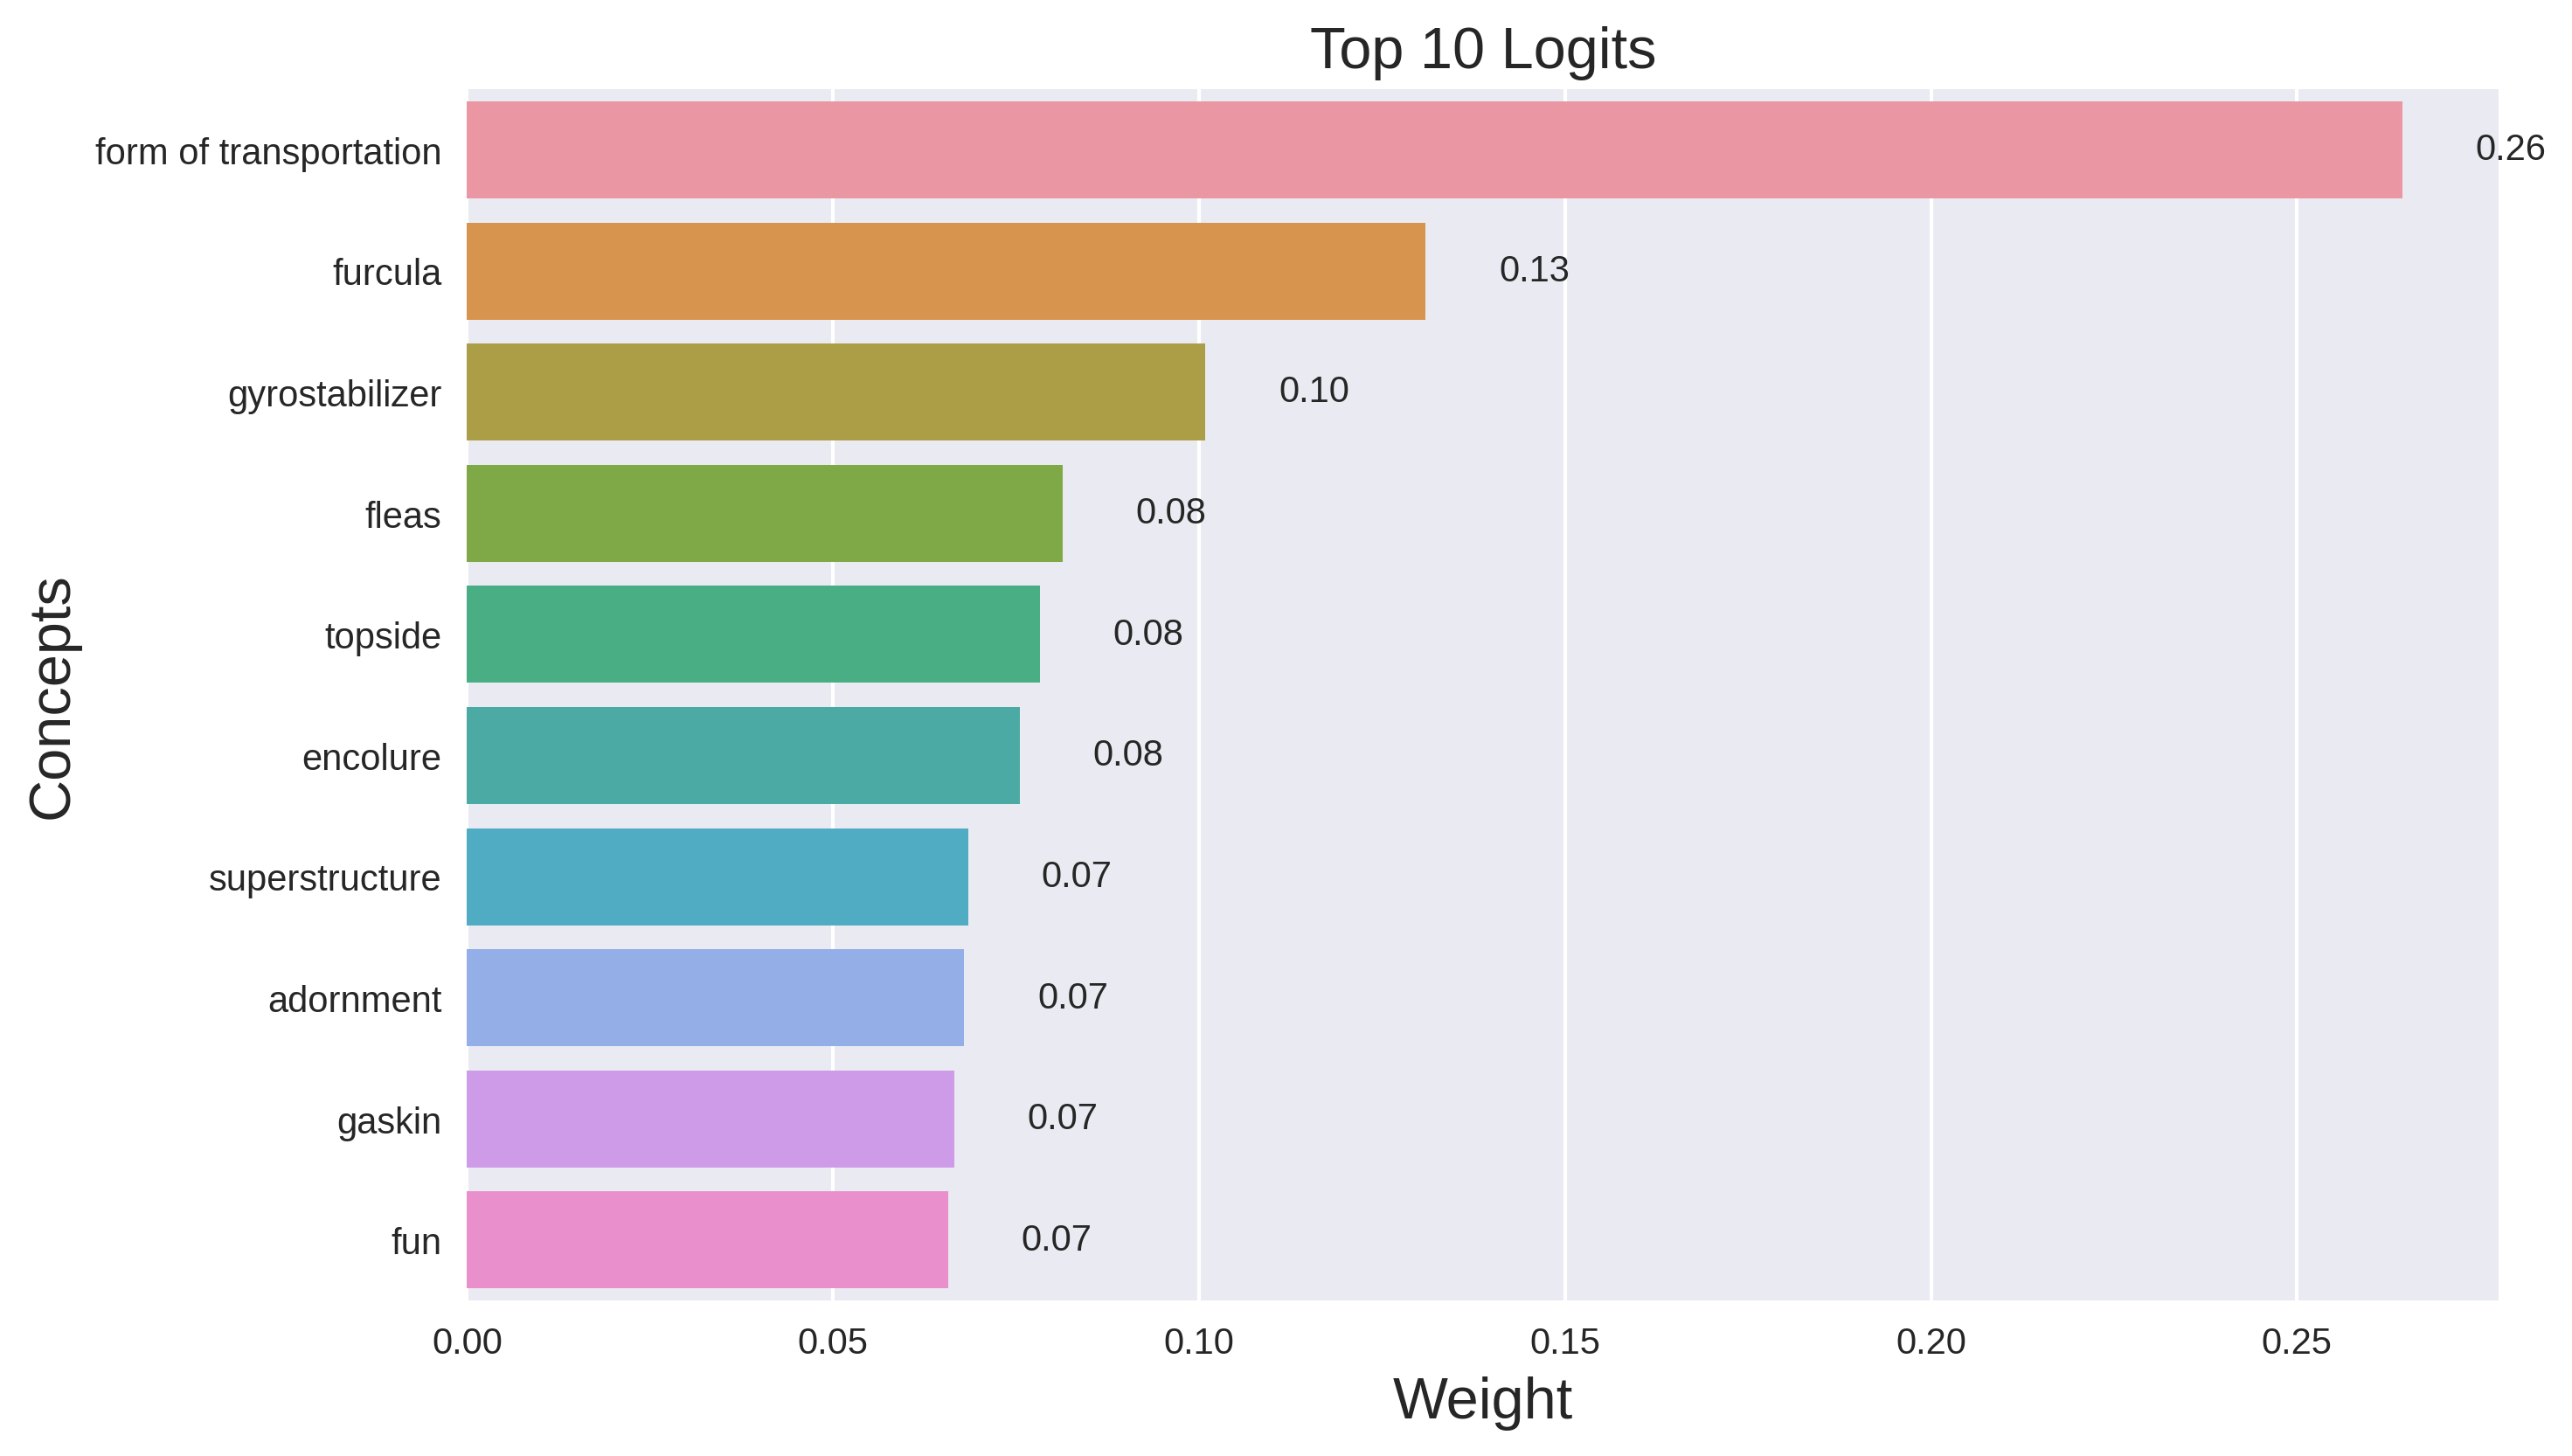

In [19]:
with torch.no_grad():
    for batch in test_loader_preprocessed:
        _, labels = batch
        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
        cbl_logits, logits = trainer.nets[1](**inputs)
        draw_bottleneck(image, cbl_logits, k=10, concepts=concepts, draw_probs=True)
        break

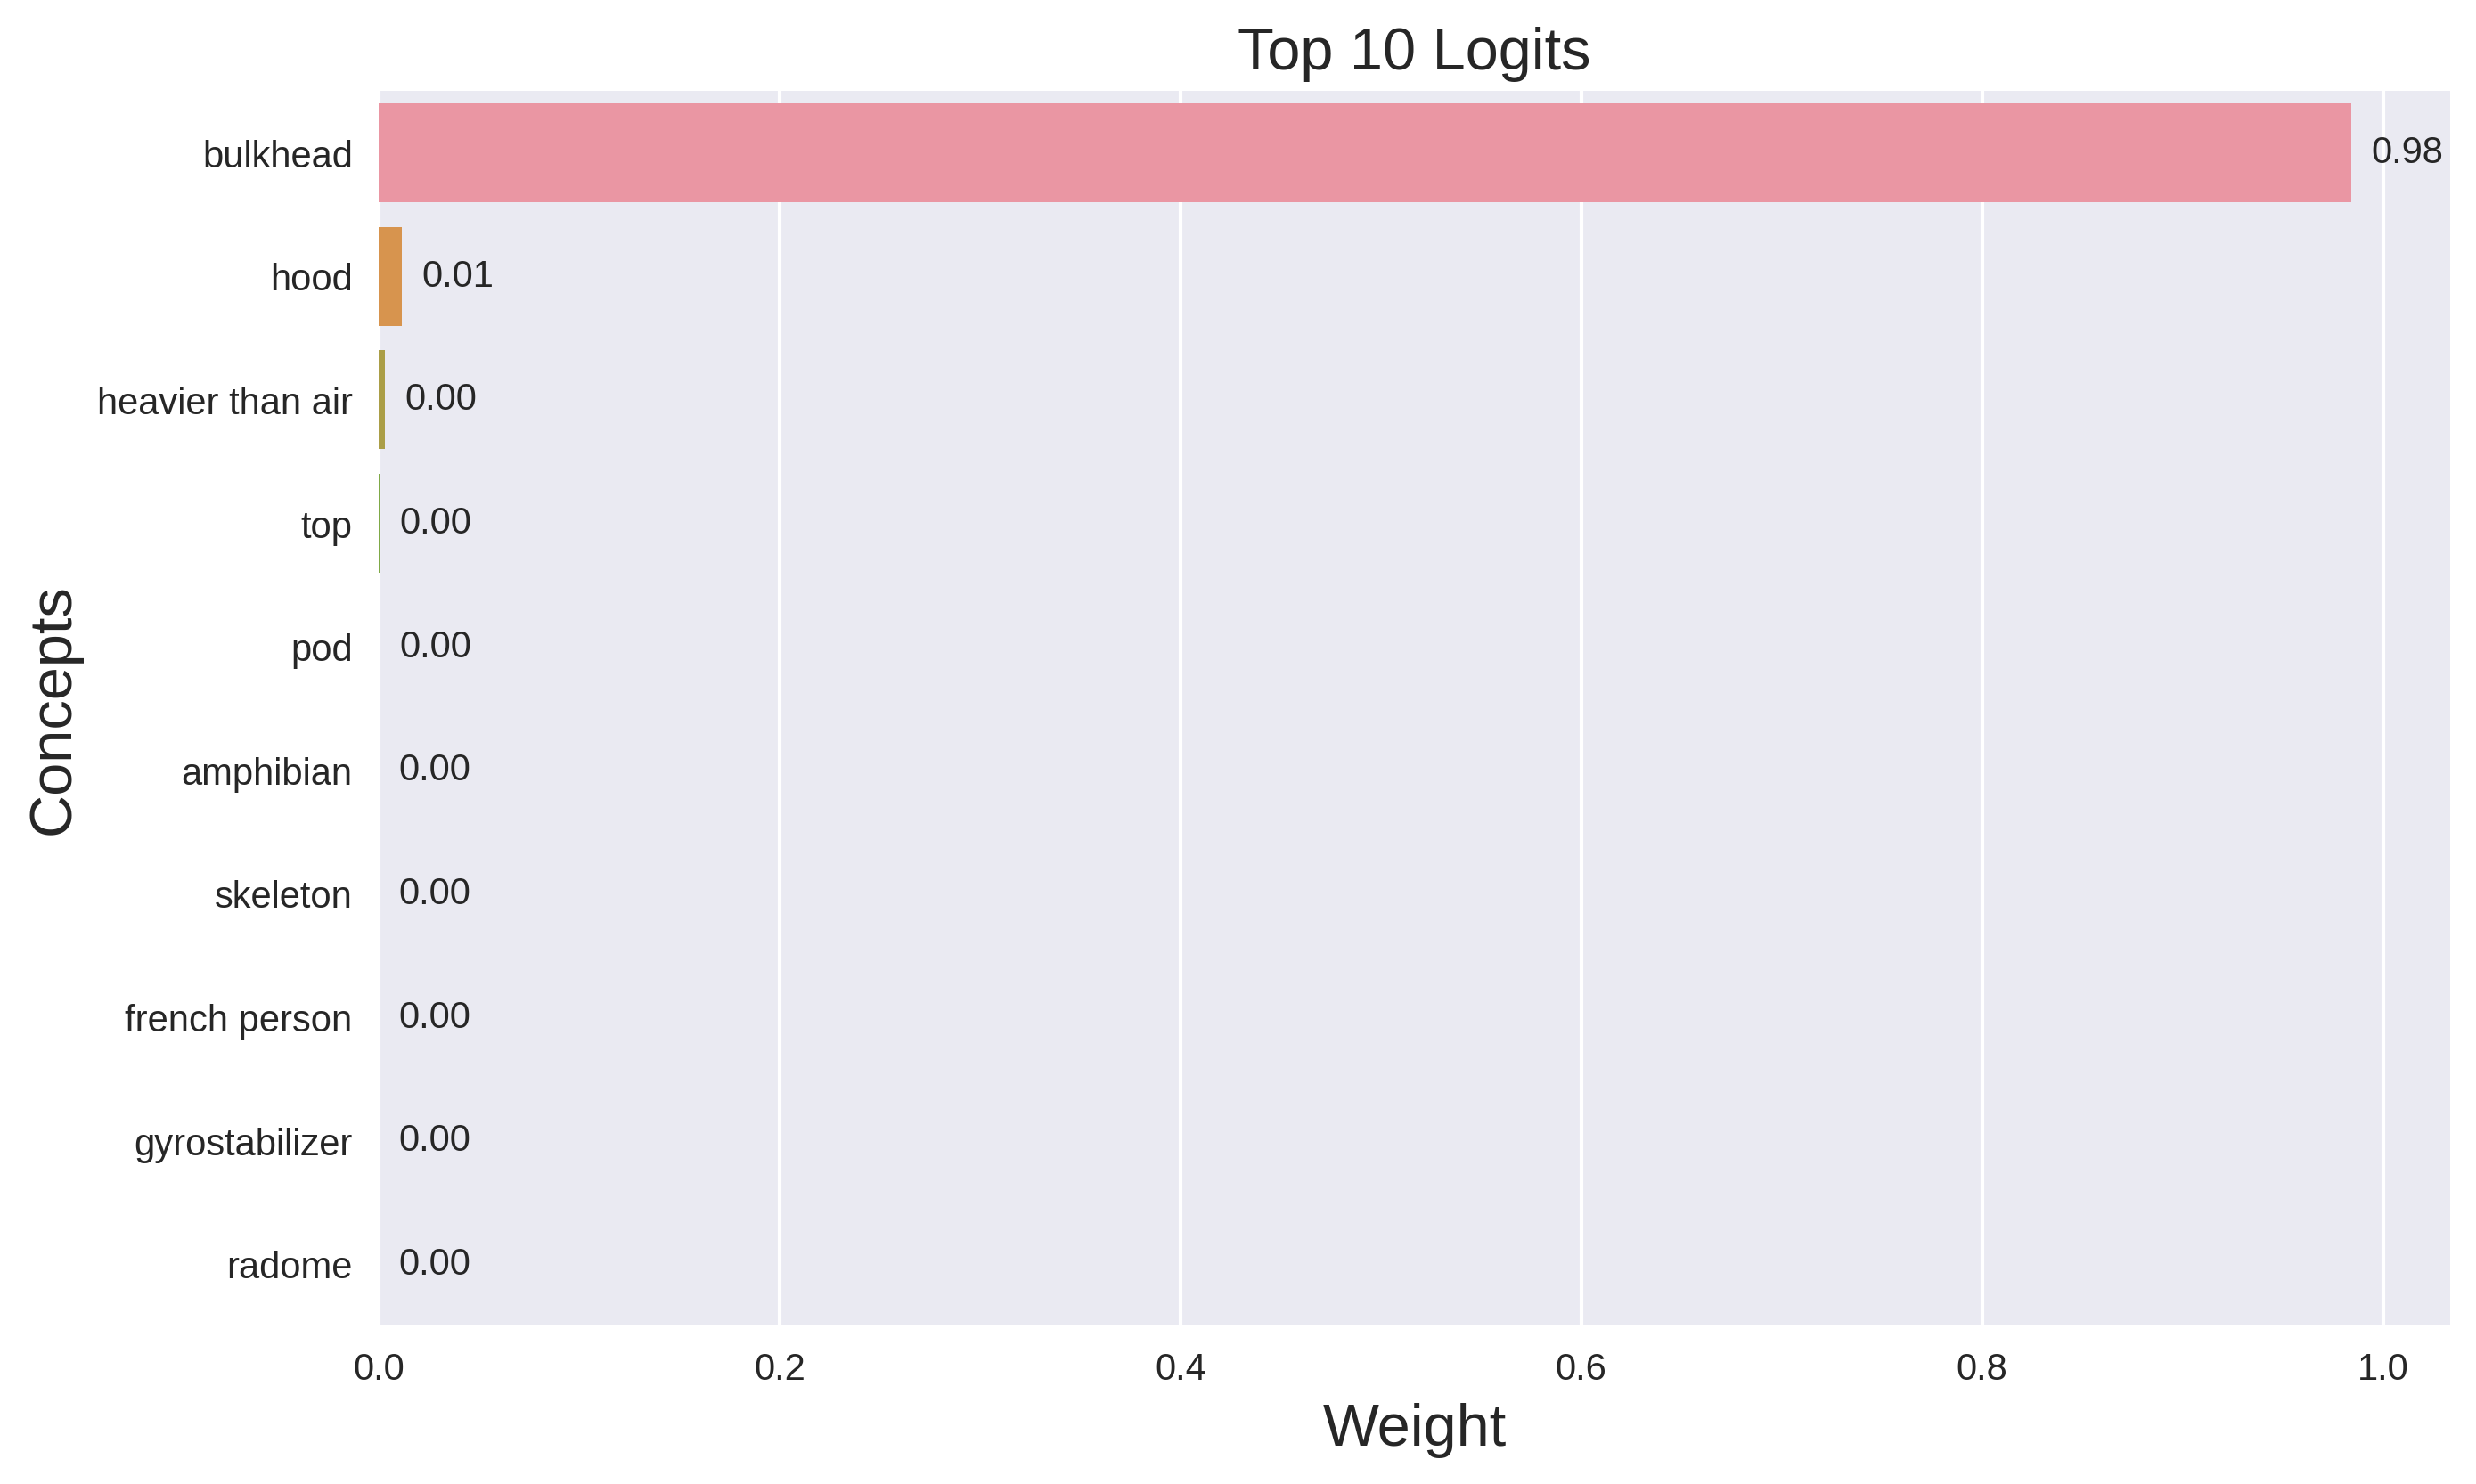

In [22]:
with torch.no_grad():
    for batch in test_loader_preprocessed:
        _, labels = batch
        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
        cbl_logits, logits = trainer.nets[0](**inputs)
        draw_bottleneck(image, cbl_logits, k=10, concepts=concepts, draw_probs=True)
        break

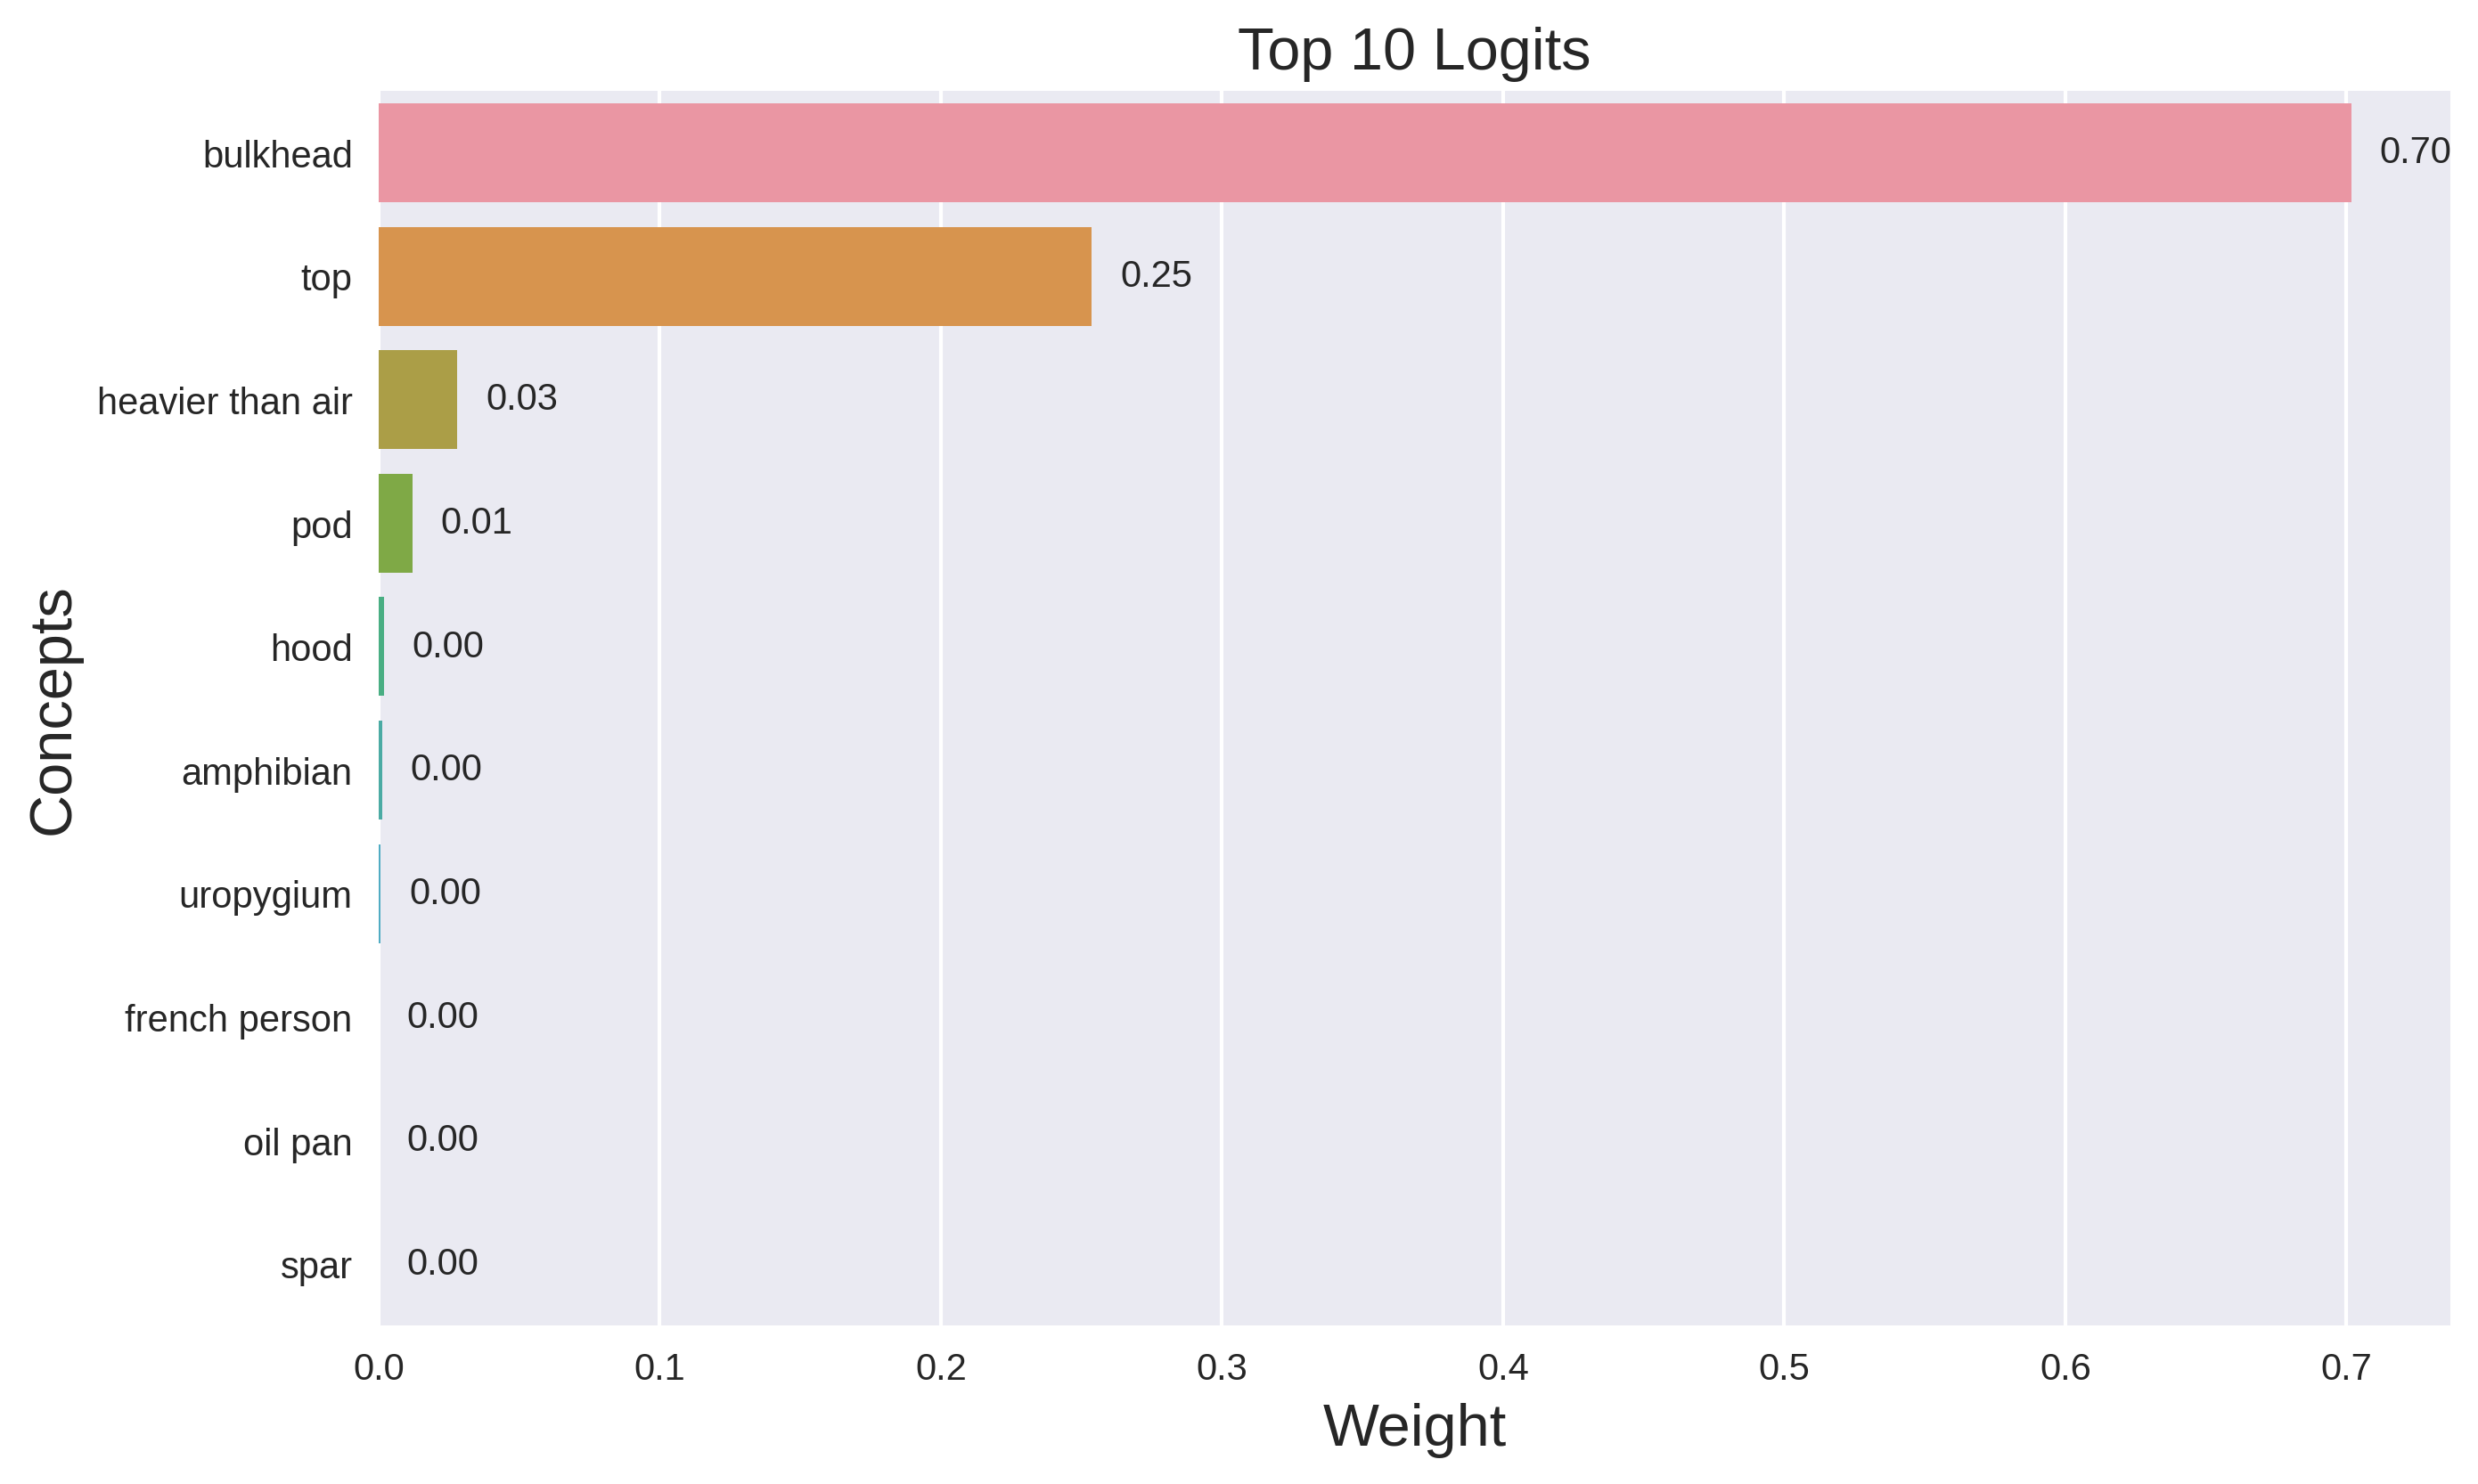

In [23]:
image_3 = PIL.Image.open("image-3.jpg")
inputs = processor(text=concepts, images=image_3, return_tensors="pt", padding=True)

with torch.no_grad():
    for batch in test_loader_preprocessed:
        _, labels = batch
        inputs, targets = inputs.to(device), torch.LongTensor(labels).to(device)
        cbl_logits, logits = trainer.nets[0](**inputs)
        draw_bottleneck(image_3, cbl_logits, k=10, concepts=concepts, draw_probs=True)
        break